Baseball Case Study Project


Problem Statement:

This dataset utilizes data from 2014 Major League Baseball seasons in order to develop an algorithm that predicts the number of wins for a given team in the 2015 season based on several different indicators of success. There are 16 different features that will be used as the inputs to the machine learning and the output will be a value that represents the number of wins.

-- Input features: Runs, At Bats, Hits, Doubles, Triples, Homeruns, Walks, Strikeouts, Stolen Bases, Runs Allowed, Earned Runs, Earned Run Average (ERA), Shutouts, Saves, Complete Games and Errors

-- Output: Number of predicted wins (W)

To understand the columns meaning, follow the link given below to understand the baseball statistics: https://en.wikipedia.org/wiki/Baseball_statistics

Importing the necessary libraries 

In [1]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore

from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
!pip3 install xgboost
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Downloading the dataset into computer from github

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/Data-Science-ML-Capstone-Projects/master/baseball.csv")

In [3]:
df.head()

,W,R,AB,H,2B,3B,HR,BB,SO,SB,RA,ER,ERA,CG,SHO,SV,E
0,95,724,5575,1497,300,42,139,383,973,104,641,601,3.73,2,8,56,88
1,83,696,5467,1349,277,44,156,439,1264,70,700,653,4.07,2,12,45,86
2,81,669,5439,1395,303,29,141,533,1157,86,640,584,3.67,11,10,38,79
3,76,622,5533,1381,260,27,136,404,1231,68,701,643,3.98,7,9,37,101
4,74,689,5605,1515,289,49,151,455,1259,83,803,746,4.64,7,12,35,86


In the above cell we are taking a look at our dataset which seems to be very small but due to the columns not being descriptive we are unable to understand the content much. We will take help from the Wikipedia link that was provided to get further insights on our dataset during it's analysis process.

However in the problem statement itself we have the below information given to us.

Input features: Runs, At Bats, Hits, Doubles, Triples, Homeruns, Walks, Strikeouts, Stolen Bases, Runs Allowed, Earned Runs, Earned Run Average (ERA), Shutouts, Saves, Complete Games and Errors

Output label: Number of predicted wins (W)

Exploratory Data Analysis (EDA)

In [4]:
df.columns

Index(['W', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'RA', 'ER',
       'ERA', 'CG', 'SHO', 'SV', 'E'],
      dtype='object')

Here we have listed all the column names present in our data that is not making much sense and will need deciphering to be converted into understandable format.

Pitching statistics:

-> W – Win: number of games where pitcher was pitching while their team took the lead and went on to win, also the starter needs to pitch at least 5 innings of work (also related: winning percentage)
-> RA – Run average: number of runs allowed times nine divided by innings pitched
-> ER – Earned run: number of runs that did not occur as a result of errors or passed balls
-> ERA – Earned run average: total number of earned runs (see "ER" above), multiplied by 9, divided by innings pitched
-> CG – Complete game: number of games where player was the only pitcher for their team
-> SHO – Shutout: number of complete games pitched with no runs allowed
-> SV – Save: number of games where the pitcher enters a game led by the pitcher's team, finishes the game without surrendering the lead, is not the winning pitcher, and either (a) the lead was three runs or fewer when the pitcher entered the game; (b) the potential tying run was on base, at bat, or on deck; or (c) the pitcher pitched three or more innings

Batting statistics:

-> R – Runs scored: number of times a player crosses home plate
-> AB – At bat: plate appearances, not including bases on balls, being hit by pitch, sacrifices, interference, or obstruction
-> H – Hit: reaching base because of a batted, fair ball without error by the defense
-> 2B – Double: hits on which the batter reaches second base safely without the contribution of a fielding error
-> 3B – Triple: hits on which the batter reaches third base safely without the contribution of a fielding error
-> HR – Home runs: hits on which the batter successfully touched all four bases, without the contribution of a fielding error
-> BB – Base on balls (also called a "walk"): hitter not swinging at four pitches called out of the strike zone and awarded first base.
-> K – Strike out (also abbreviated SO): number of times that a third strike is taken or swung at and missed, or bunted foul. Catcher must catch the third strike or batter may attempt to run to first base.

Baserunning statistics:

-> SB – Stolen base: number of bases advanced by the runner while the ball is in the possession of the defense
-> R – Runs scored: times reached home plate legally and safely

Fielding statistics:

-> E – Errors: number of times a fielder fails to make a play he should have made with common effort, and the offense benefits as a result

Now that we have clearer understanding on what the abbreviation mean and that they come from different statistics we should be able to figure out the scoring procedure details.

In [5]:
df.rename(columns={'W' : 'Wins', 
                   'R' : 'Runs Scored', 
                  'AB' : 'At Bat', 
                   'H' : 'Hits', 
                  '2B' : 'Doubles', 
                  '3B' : 'Triples',
                  'HR' : 'Home Runs', 
                  'BB' : 'Base on Balls', 
                  'SO' : 'Strike Outs', 
                  'SB' : 'Stolen Base',
                  'RA' : 'Runs Average', 
                  'ER' : 'Earned Runs', 
                 'ERA' : 'Earned Run Average', 
                  'CG' : 'Complete Game',
                 'SHO' : 'Shut Outs', 
                  'SV' : 'Saves', 
                   'E' : 'Errors'}, 
          inplace=True)

df.head()

,Wins,Runs Scored,At Bat,Hits,Doubles,Triples,Home Runs,Base on Balls,Strike Outs,Stolen Base,Runs Average,Earned Runs,Earned Run Average,Complete Game,Shut Outs,Saves,Errors
0,95,724,5575,1497,300,42,139,383,973,104,641,601,3.73,2,8,56,88
1,83,696,5467,1349,277,44,156,439,1264,70,700,653,4.07,2,12,45,86
2,81,669,5439,1395,303,29,141,533,1157,86,640,584,3.67,11,10,38,79
3,76,622,5533,1381,260,27,136,404,1231,68,701,643,3.98,7,9,37,101
4,74,689,5605,1515,289,49,151,455,1259,83,803,746,4.64,7,12,35,86


After we were able to decipher the meaning of all the given abbreviations thanks to the Wikipedia page I have now replaced all the column names with their understandable full forms for understanding purpose.

Here we can clearly see that the "Wins" column is our target label and the remaining columns are our features that will determine and help us predicting the wins in a particular baseball game. As the target label "Wins" comprises of all continous data it makes this to be a Regression problem!

In [6]:
df.shape

(30, 17)

With the help of the shape method we can see that our dataset only has 30 rows and 17 columns and we will need to try and retain all the given information while building our ML model.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Wins                30 non-null     int64  
 1   Runs Scored         30 non-null     int64  
 2   At Bat              30 non-null     int64  
 3   Hits                30 non-null     int64  
 4   Doubles             30 non-null     int64  
 5   Triples             30 non-null     int64  
 6   Home Runs           30 non-null     int64  
 7   Base on Balls       30 non-null     int64  
 8   Strike Outs         30 non-null     int64  
 9   Stolen Base         30 non-null     int64  
 10  Runs Average        30 non-null     int64  
 11  Earned Runs         30 non-null     int64  
 12  Earned Run Average  30 non-null     float64
 13  Complete Game       30 non-null     int64  
 14  Shut Outs           30 non-null     int64  
 15  Saves               30 non-null     int64  
 16  Errors    

In the info method we are able to take a look at the data types of our dataset columns. It shows that we have 16 columns with integer datatype and 1 column with float datatype. Since there are no object datatype present in our dataset no encoding process will be needed.

In [8]:
df.isna().sum()

Wins                  0
Runs Scored           0
At Bat                0
Hits                  0
Doubles               0
Triples               0
Home Runs             0
Base on Balls         0
Strike Outs           0
Stolen Base           0
Runs Average          0
Earned Runs           0
Earned Run Average    0
Complete Game         0
Shut Outs             0
Saves                 0
Errors                0
dtype: int64

We have no missing data in our dataset either so we won't have to worry about handling missing data either and can simply check for skewness and outlier details now.

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Wins,30.0,80.966667,10.453455,63.00,74.0000,81.000,87.75,100.00
Runs Scored,30.0,688.233333,58.761754,573.00,651.2500,689.000,718.25,891.00
At Bat,30.0,5516.266667,70.467372,5385.00,5464.0000,5510.000,5570.00,5649.00
Hits,30.0,1403.533333,57.140923,1324.00,1363.0000,1382.500,1451.50,1515.00
Doubles,30.0,274.733333,18.095405,236.00,262.2500,275.500,288.75,308.00
Triples,30.0,31.300000,10.452355,13.00,23.0000,31.000,39.00,49.00
Home Runs,30.0,163.633333,31.823309,100.00,140.2500,158.500,177.00,232.00
Base on Balls,30.0,469.100000,57.053725,375.00,428.2500,473.000,501.25,570.00
Strike Outs,30.0,1248.200000,103.759470,973.00,1157.5000,1261.500,1311.50,1518.00
Stolen Base,30.0,83.500000,22.815225,44.00,69.0000,83.500,96.50,134.00


As there were many column we are using the Transpose method to view the description details clearly. Looking at the first column we can clearly see that all of them have 30.0 as their count confirming no missing values.

Also when we try to eye ball the other columns like mean, standard deviation, minimum values, 25% quartile, 50% quartile, 75% quartile and maximum values then they are seem to be progressing in a definite manner showing no visible abnormalities.

In [10]:
df.skew()

Wins                  0.047089
Runs Scored           1.200786
At Bat                0.183437
Hits                  0.670254
Doubles              -0.230650
Triples               0.129502
Home Runs             0.516441
Base on Balls         0.158498
Strike Outs          -0.156065
Stolen Base           0.479893
Runs Average          0.045734
Earned Runs           0.058710
Earned Run Average    0.053331
Complete Game         0.736845
Shut Outs             0.565790
Saves                 0.657524
Errors                0.890132
dtype: float64

The acceptable range for skewness is between +/-0.5. We see columns such as Runs Scored, Hits, Runs Average, Earned Runs, Earned Run Average, Complete Game, Saves and Errors being slightly out of this range.

We shall inspect further in regards to the skewness information to determin whether it needs to be treated or not.

In [11]:
df.nunique()

Wins                  24
Runs Scored           28
At Bat                29
Hits                  29
Doubles               22
Triples               23
Home Runs             27
Base on Balls         29
Strike Outs           29
Stolen Base           27
Runs Average          30
Earned Runs           30
Earned Run Average    30
Complete Game          9
Shut Outs             12
Saves                 20
Errors                21
dtype: int64

Taking a look at all the unique values present in each of the columns in our dataset. It shows that there are no categorical data since even the unique numbers are large in number and cannot be segregated or combined.

Visualization

Univariate Analysis

-> Strip Plot

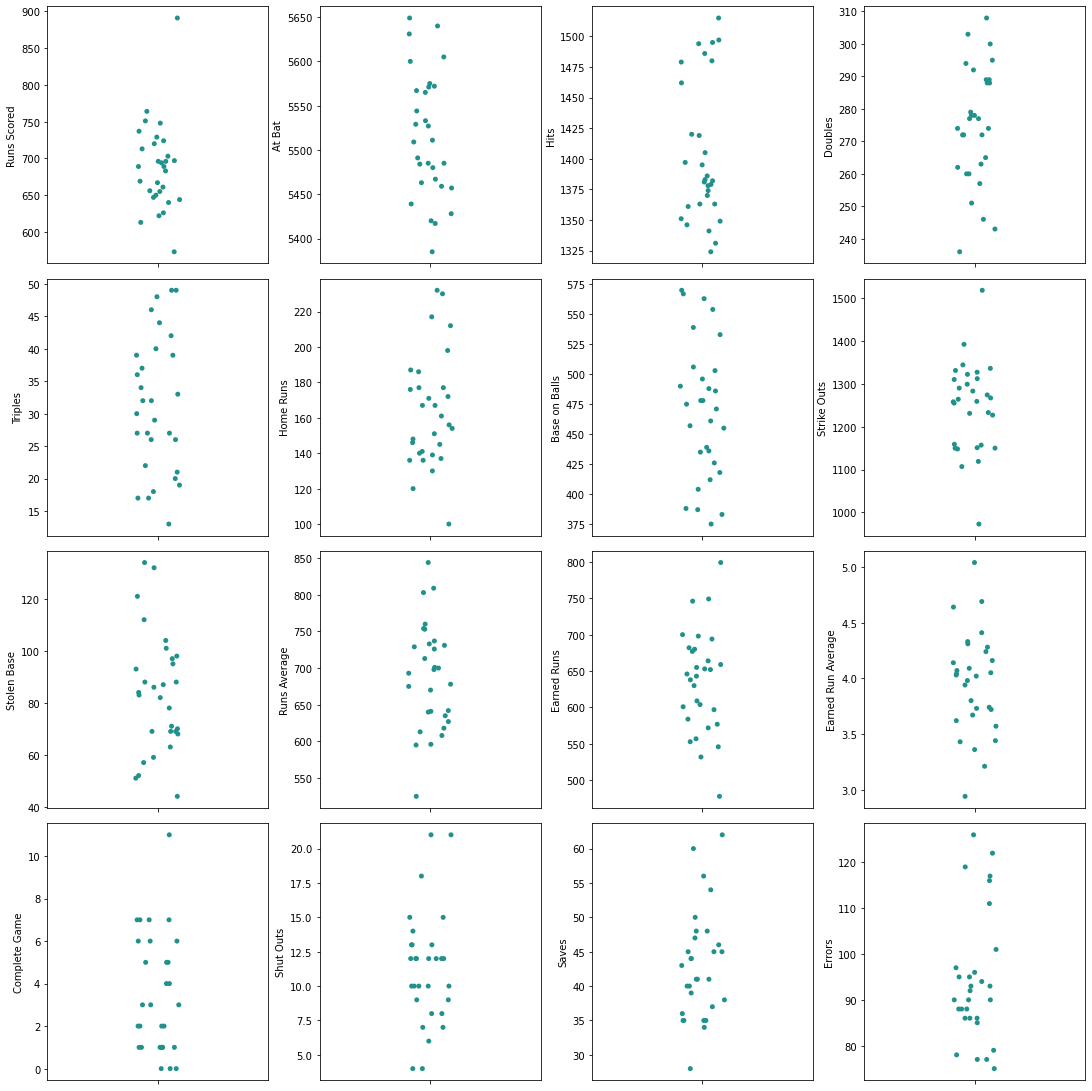

In [12]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(15,15))
index = 0
features = df.drop("Wins", axis=1)
ax = ax.flatten()
for col, value in features.items():
    sns.stripplot(y=col, data=df, ax=ax[index], palette="viridis")
    index += 1
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
plt.show()

With the help of above strip plot we are able to take a look at data point distribution across the data set and it's range details. We can see columns Runs Scored, Strike Outs, Complete Game with single data points further away from the general accumulation indicating towards the presence of ouliers.

-> Box Plot

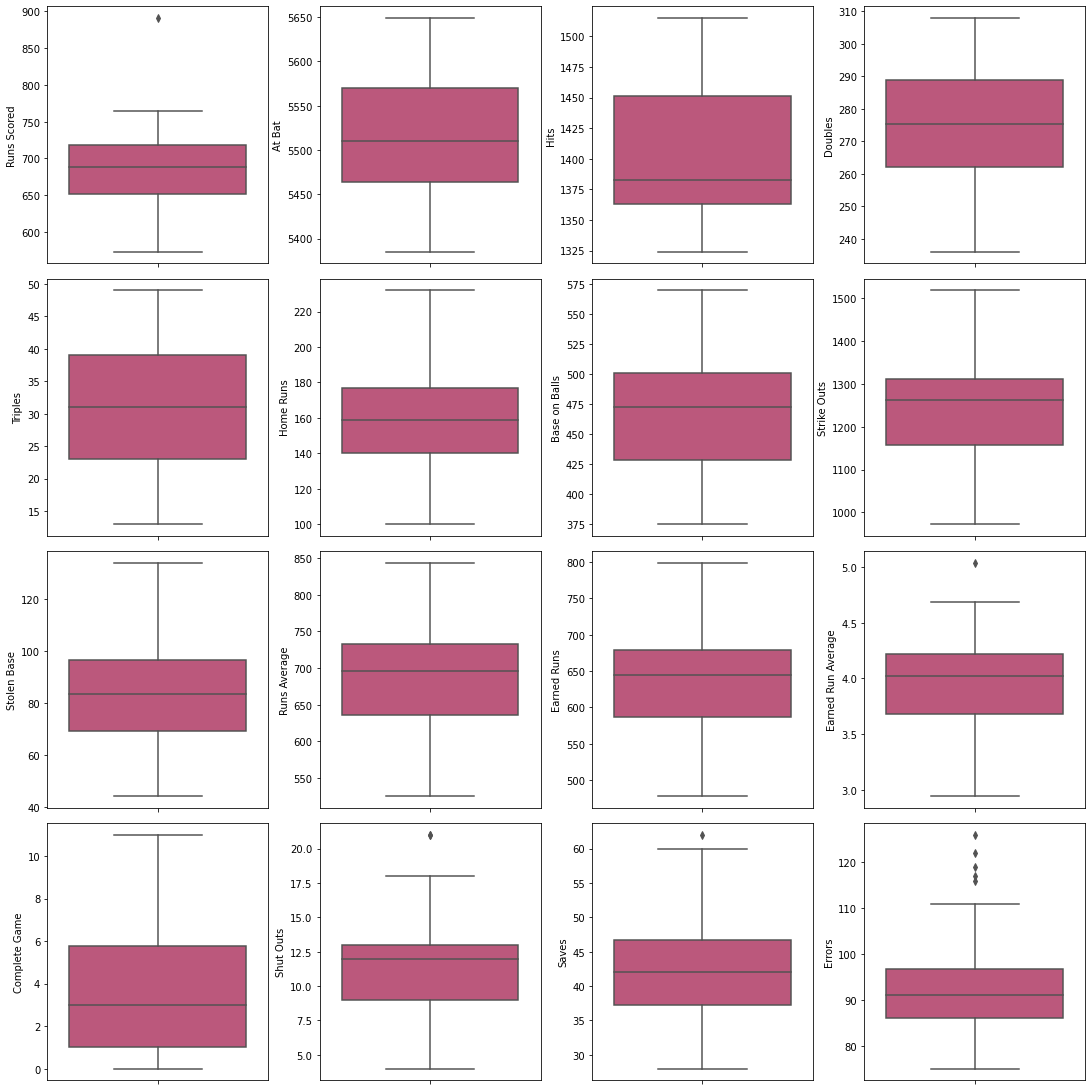

In [16]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(15,15))
index = 0
features = df.drop("Wins", axis=1)
ax = ax.flatten()
for col, value in features.items():
    sns.boxplot(y=col, data=df, ax=ax[index], palette="plasma")
    index += 1
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
plt.show()

The above box plot representation clearly shows few outlier points present in Runs Scored, Earned Run Average, Shut Outs, Saves and Errors. These will need to be treated further before building our machine learning model.

-> Distribution Plot

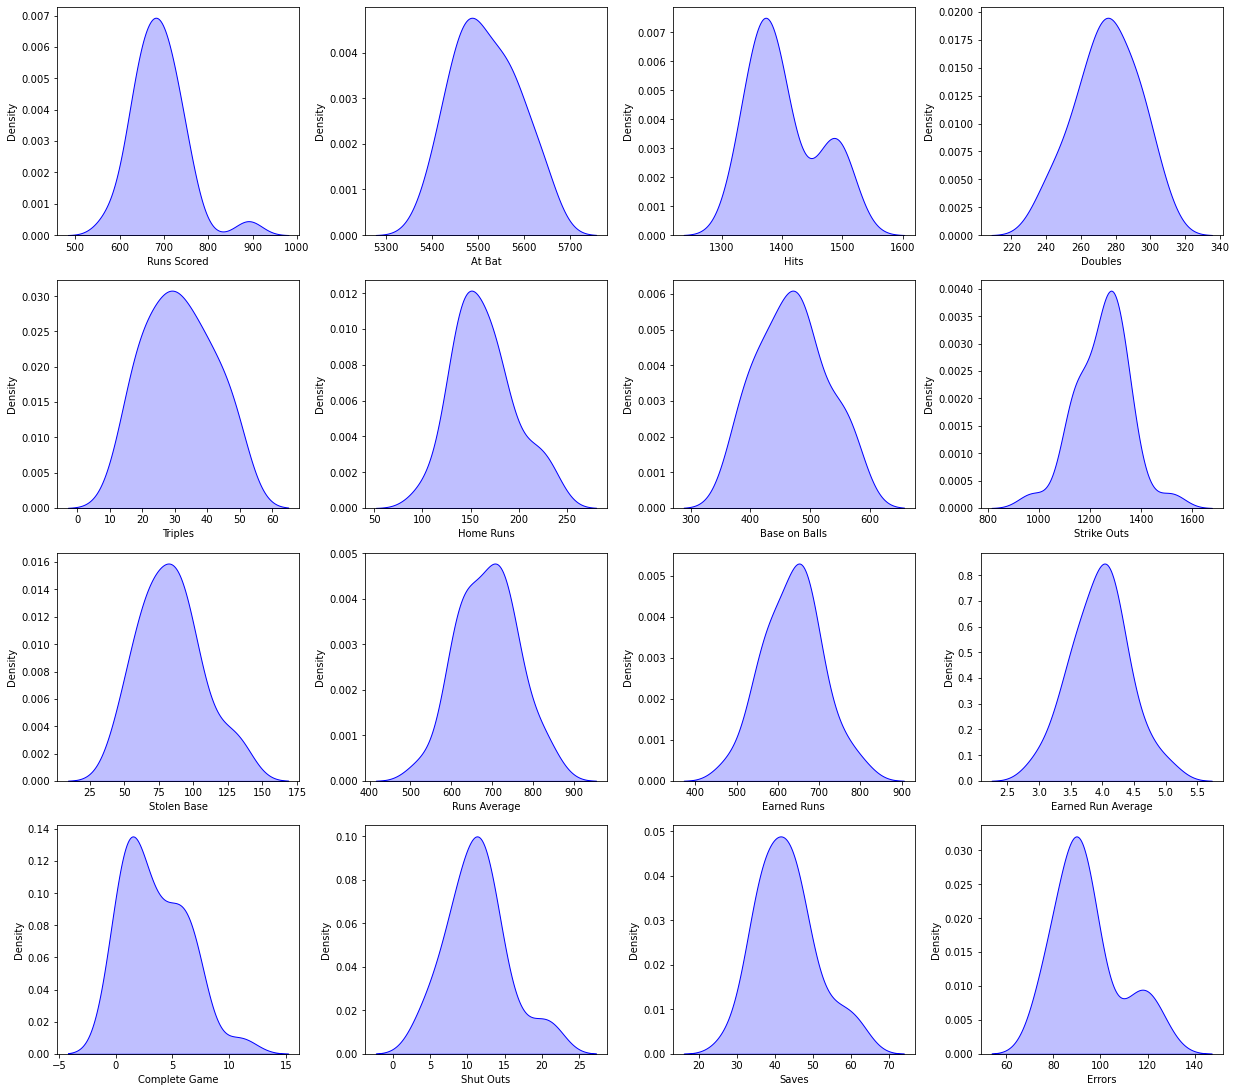

In [14]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(17,15))
index = 0
features = df.drop("Wins", axis=1)
ax = ax.flatten()
for col, value in features.items():
    sns.distplot(value, ax=ax[index], hist=False, color="blue", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
plt.show()

In the above cell we see that mostly all our column data are normally distributed except for Runs Scored, Complete Game, SHut Outs and Errors columns that have slight skewness in them and will need to be treated accordingly.

Bivariate analysis

-> Line Plot

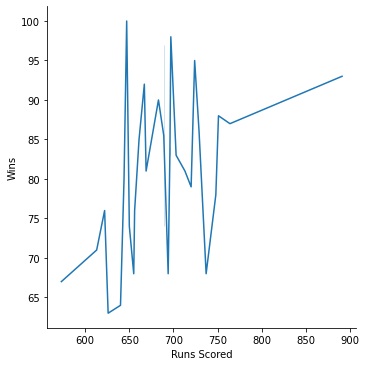

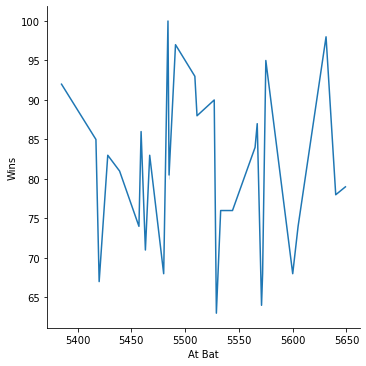

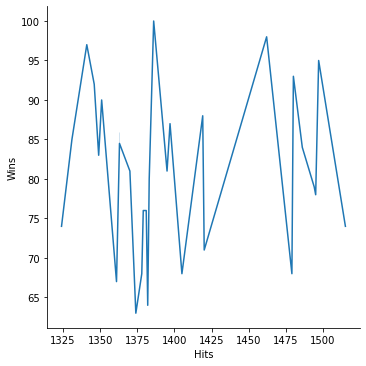

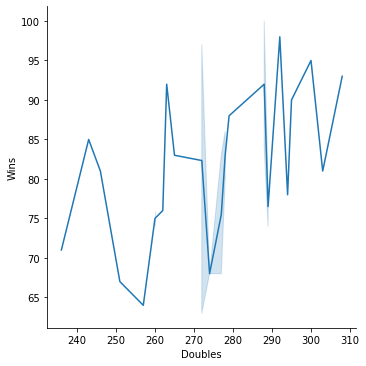

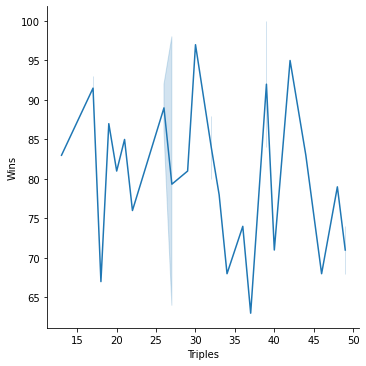

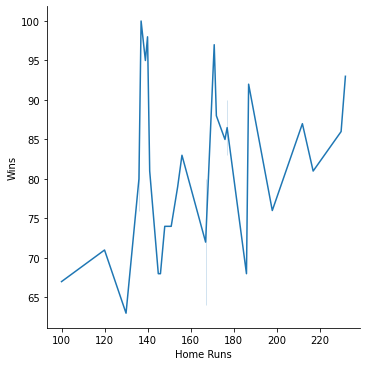

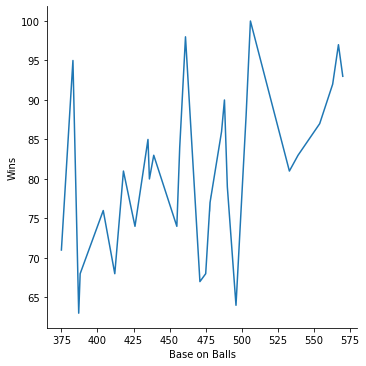

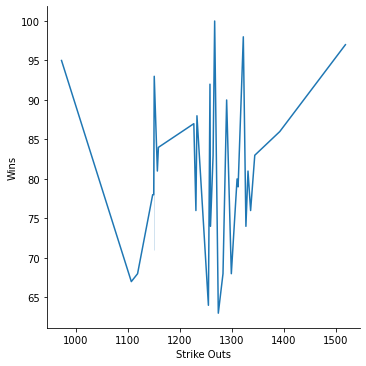

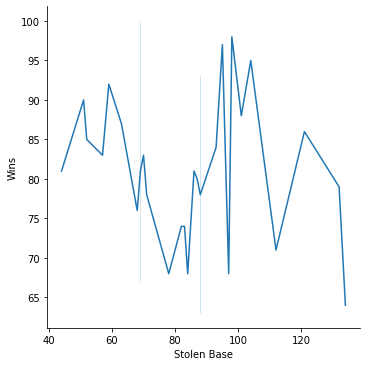

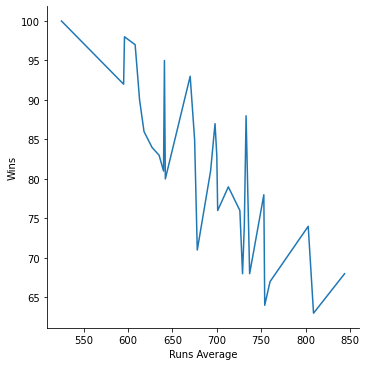

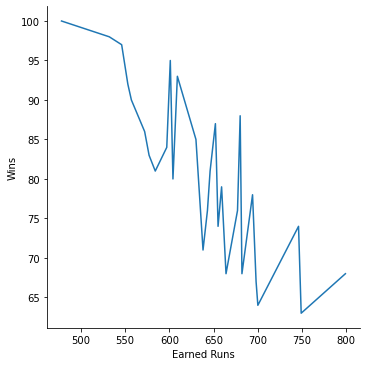

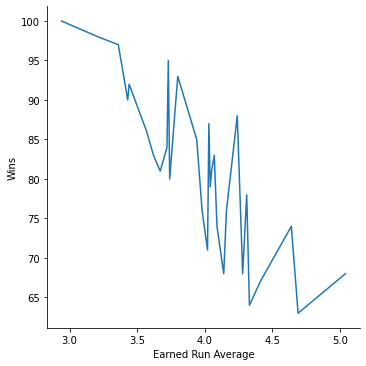

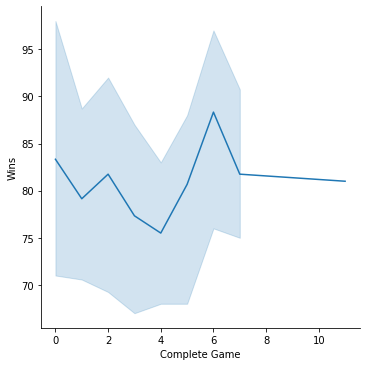

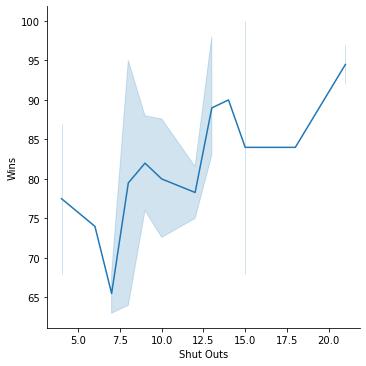

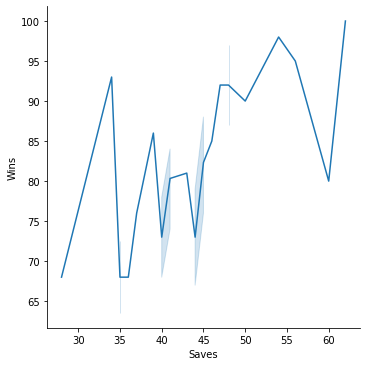

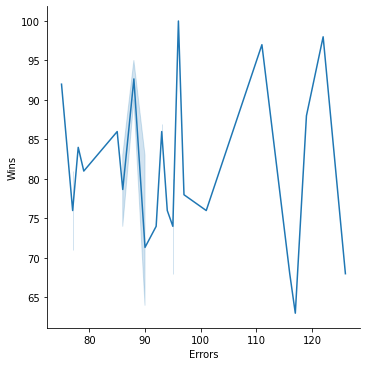

In [17]:
index = 0
features = df.drop("Wins", axis=1)
for col, value in features.items():
    sns.relplot(x=col, y="Wins", kind="line", data=df)
    index += 1
plt.show()

By taking a look at all the line plots corresponding to the "Wins" column shows how those feature are related with the contribution on getting those particular numbers. Some of them are directly proportional while others are either inversely proportional to our label or do not have much to offer.

Therefore we can say that the relationships between the label and all the features can be viewed from above graphs: All of the above features (except the errors) are positively correlated with our label In case the number of runs increases then the chance of win increases obviously In case the doubles increase then the chance of win increases In case the triples increases then the chance of win increases In case the home runs increases then the chance of win increases In case the walks on balls increases then the chance of win increases In case the strike outs increases then the chance of win increases for the opposite team In case the stolen bases increases then the chance of win increases again for the opposite team In case the runs allowed increases then the chance of win increases In case the earned run and earned run average increases the chance of win increases automatically

-> Bar Plot

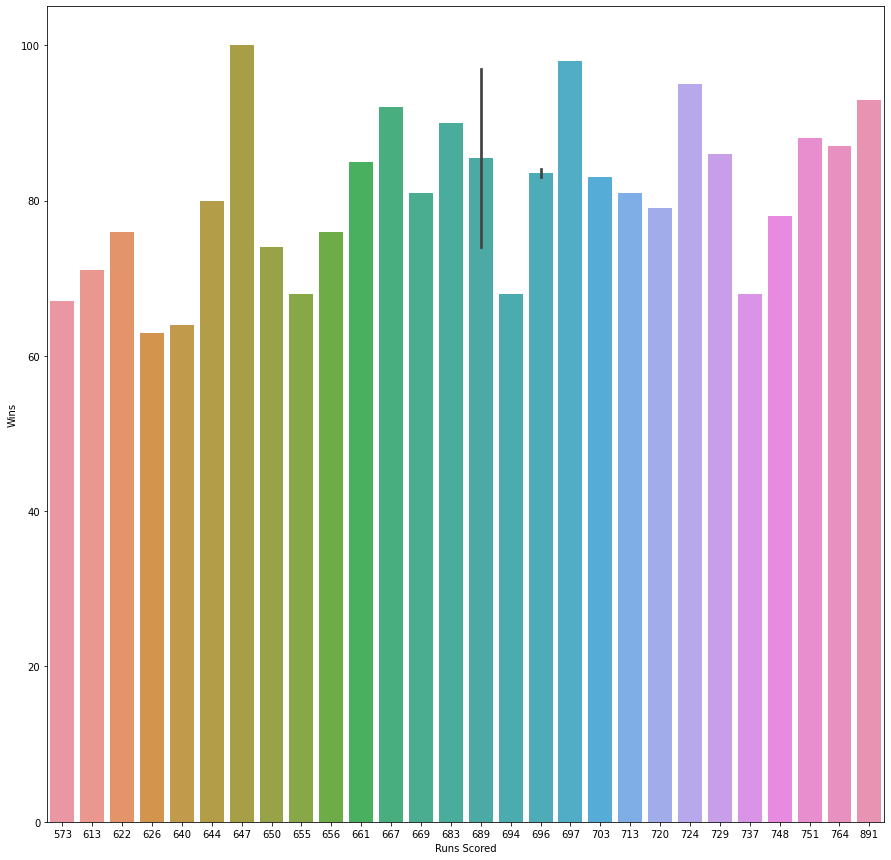

In [18]:
plt.figure(figsize=(15,15))
sns.barplot(x="Runs Scored", y="Wins", data=df)
plt.show()

Feature "Runs Scored" and it's unique values are distributed unevenly when it comes to relating with our label "Wins"

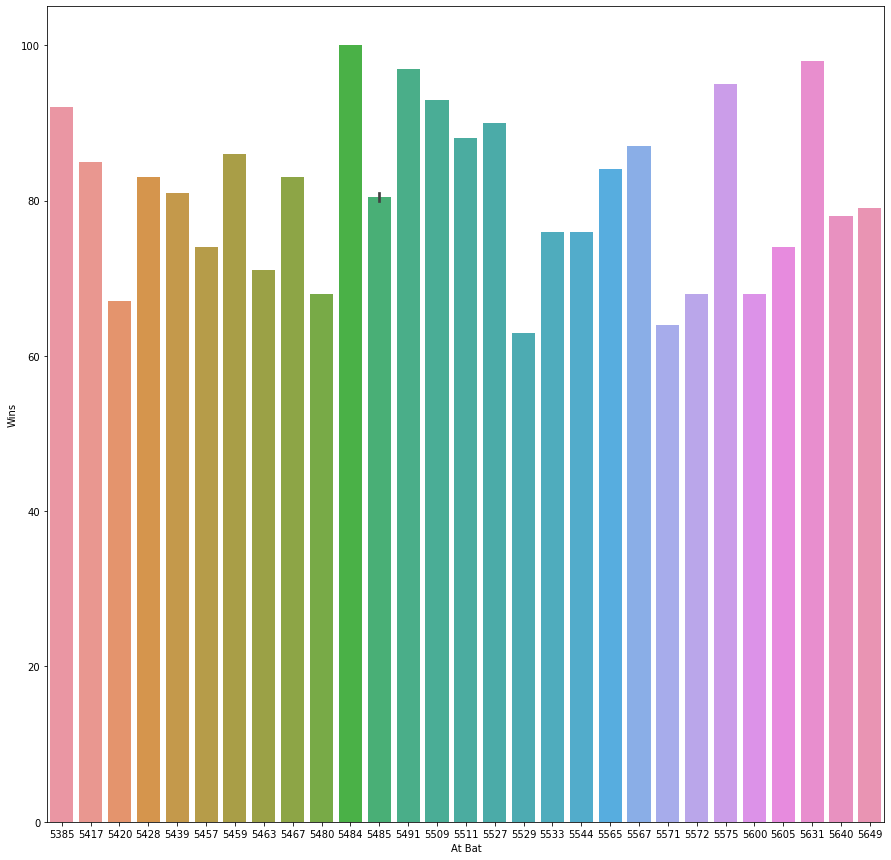

In [19]:
plt.figure(figsize=(15,15))
sns.barplot(x="At Bat", y="Wins", data=df)
plt.show()

Feature "At Bat" and it's unique values are again distributed unevenly when it comes to relating with our label "Wins"

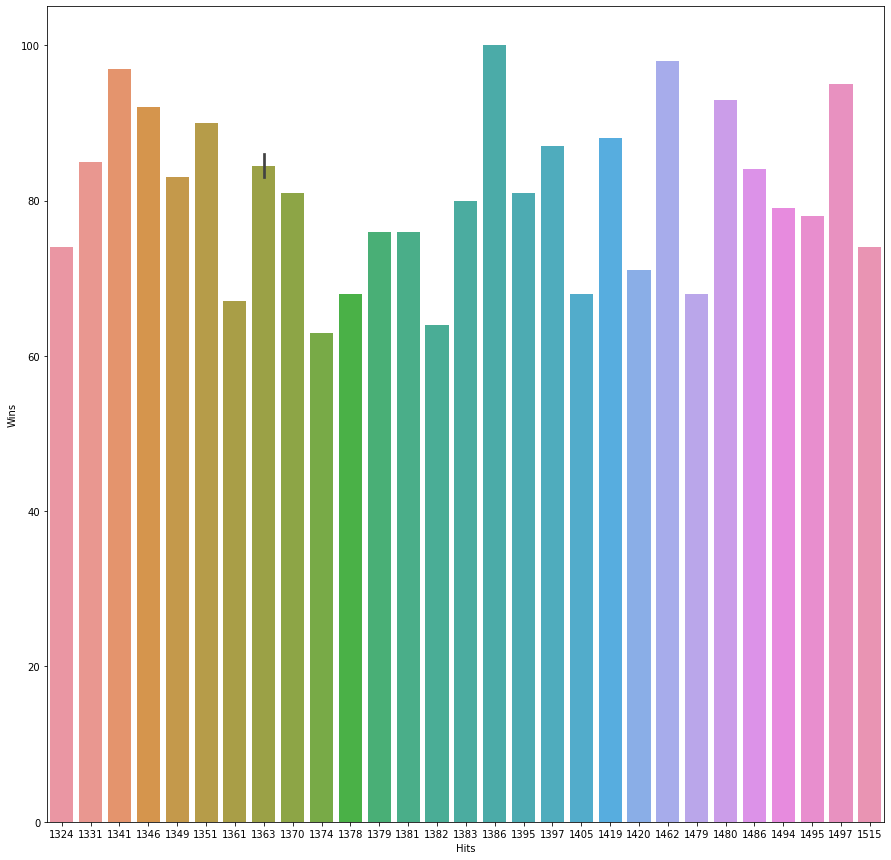

In [21]:
plt.figure(figsize=(15,15))
sns.barplot(x="Hits", y="Wins", data=df)
plt.show()

Feature "Hits" and it's unique values do not show any linear pattern when it comes to relating with our label "Wins"

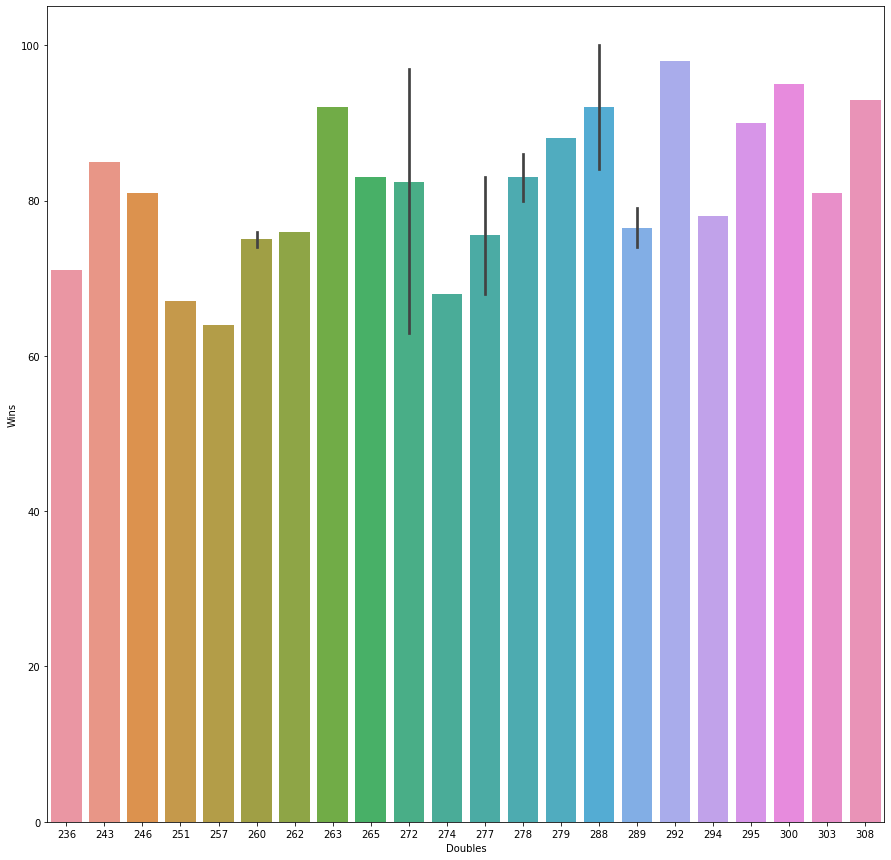

In [22]:
plt.figure(figsize=(15,15))
sns.barplot(x="Doubles", y="Wins", data=df)
plt.show()

Feature "Doubles" and it's unique values again do not form any definite pattern when it comes to relating with our label "Wins"

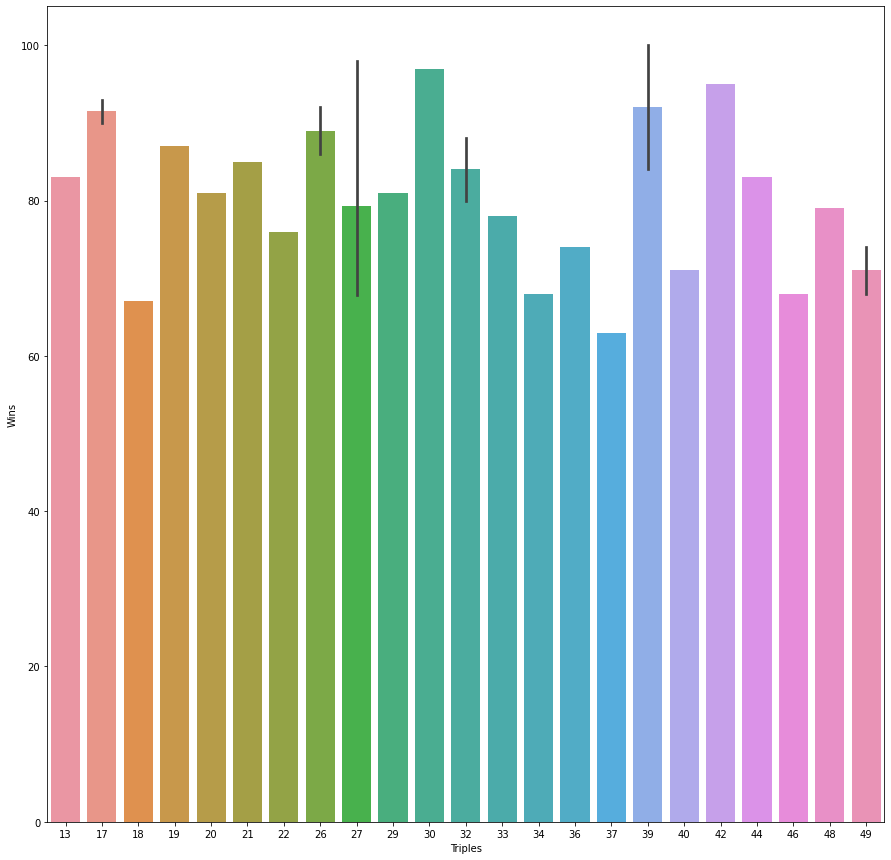

In [23]:
plt.figure(figsize=(15,15))
sns.barplot(x="Triples", y="Wins", data=df)
plt.show()

Feature "Triples" and it's unique values are distributed unevenly when it comes to relating with our label "Wins"

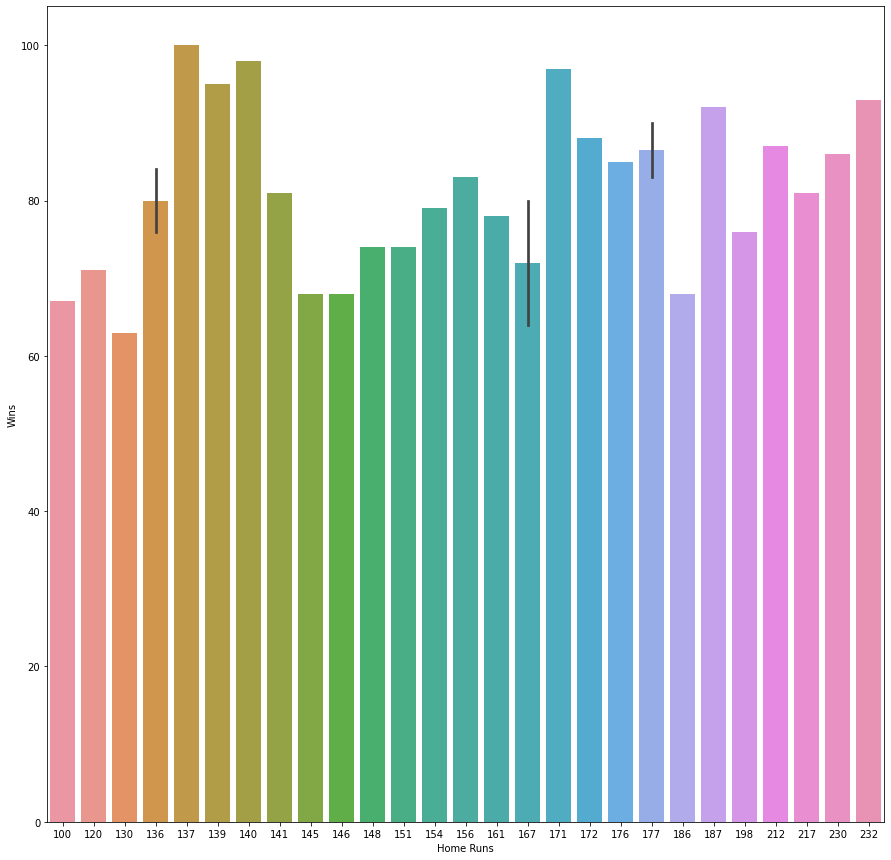

In [24]:
plt.figure(figsize=(15,15))
sns.barplot(x="Home Runs", y="Wins", data=df)
plt.show()

Feature "Home Runs" and it's unique values have no visible pattern when it comes to relating with our label "Wins"

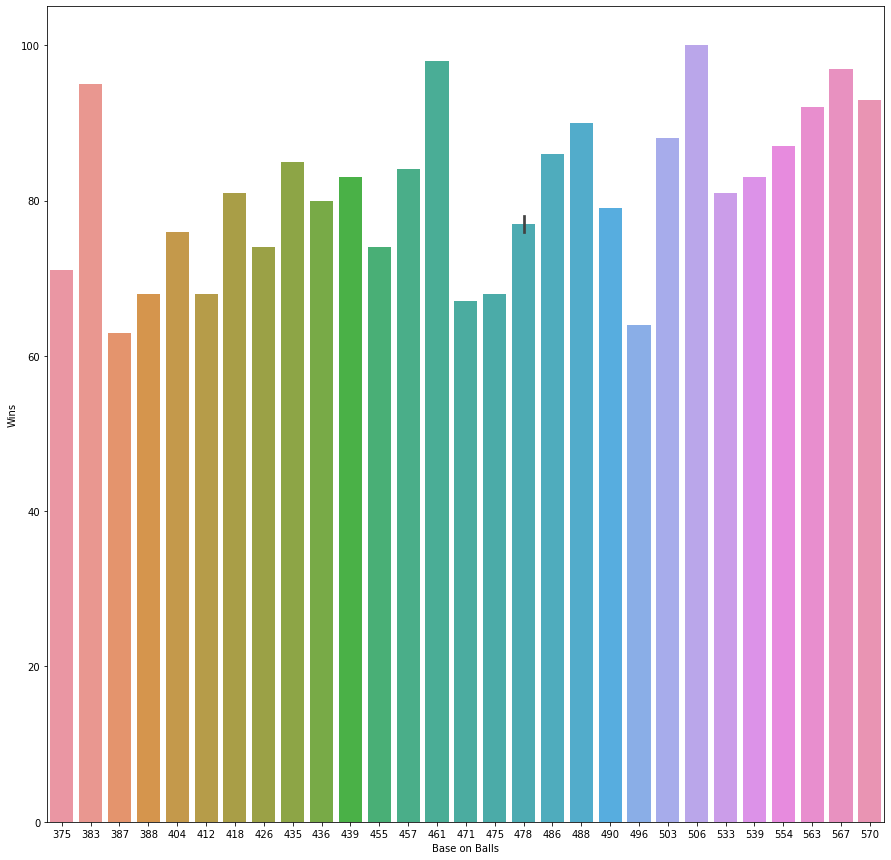

In [25]:
plt.figure(figsize=(15,15))
sns.barplot(x="Base on Balls", y="Wins", data=df)
plt.show()

Feature "Base on Balls" and it's unique values are also distributed unevenly when it comes to relating with our label "Wins"

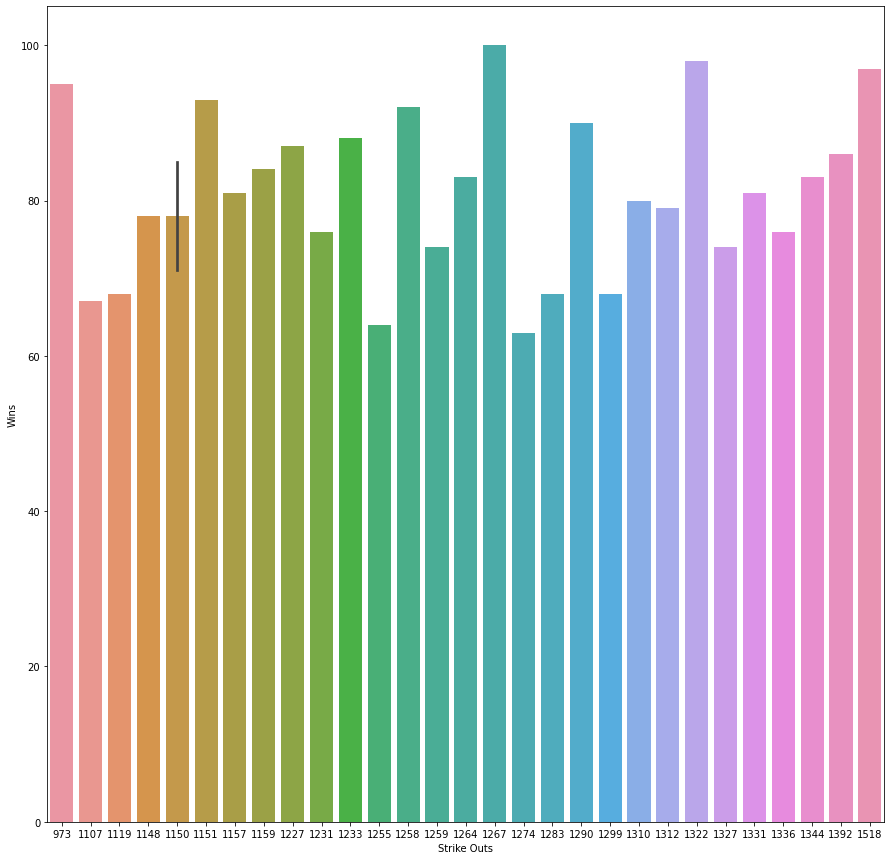

In [26]:
plt.figure(figsize=(15,15))
sns.barplot(x="Strike Outs", y="Wins", data=df)
plt.show()

Feature "Strike Outs" and it's unique values are unevenly patterned when it comes to relating with our label "Wins"

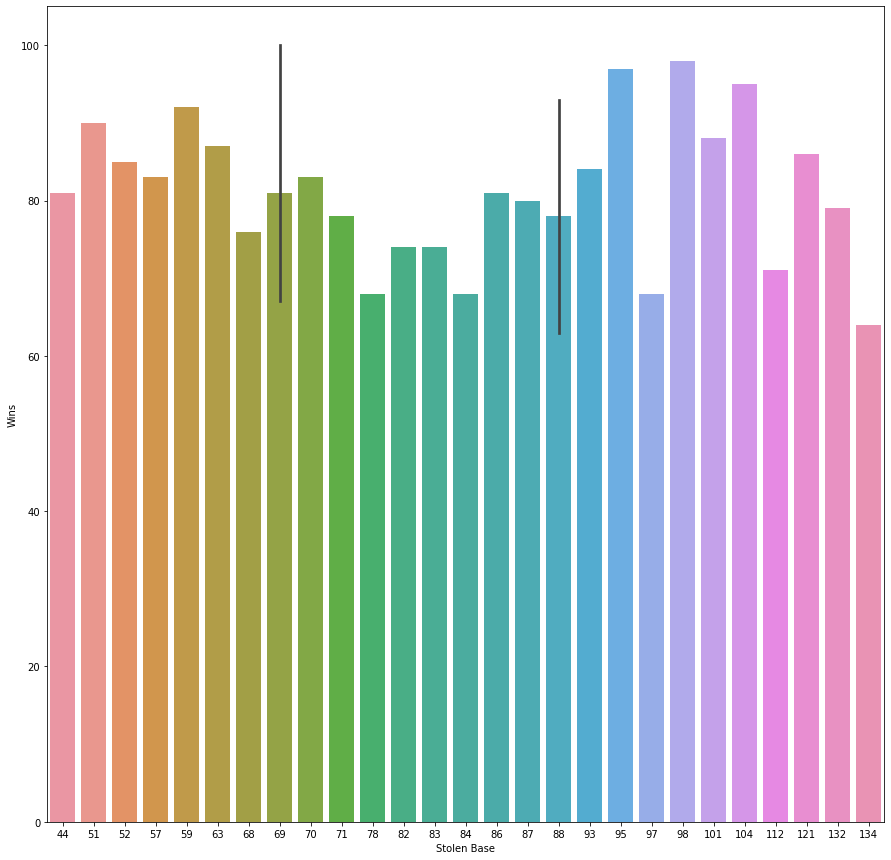

In [27]:
plt.figure(figsize=(15,15))
sns.barplot(x="Stolen Base", y="Wins", data=df)
plt.show()

Feature "Stolen Base" and it's unique values are also distributed unevenly when it comes to relating with our label "Wins"

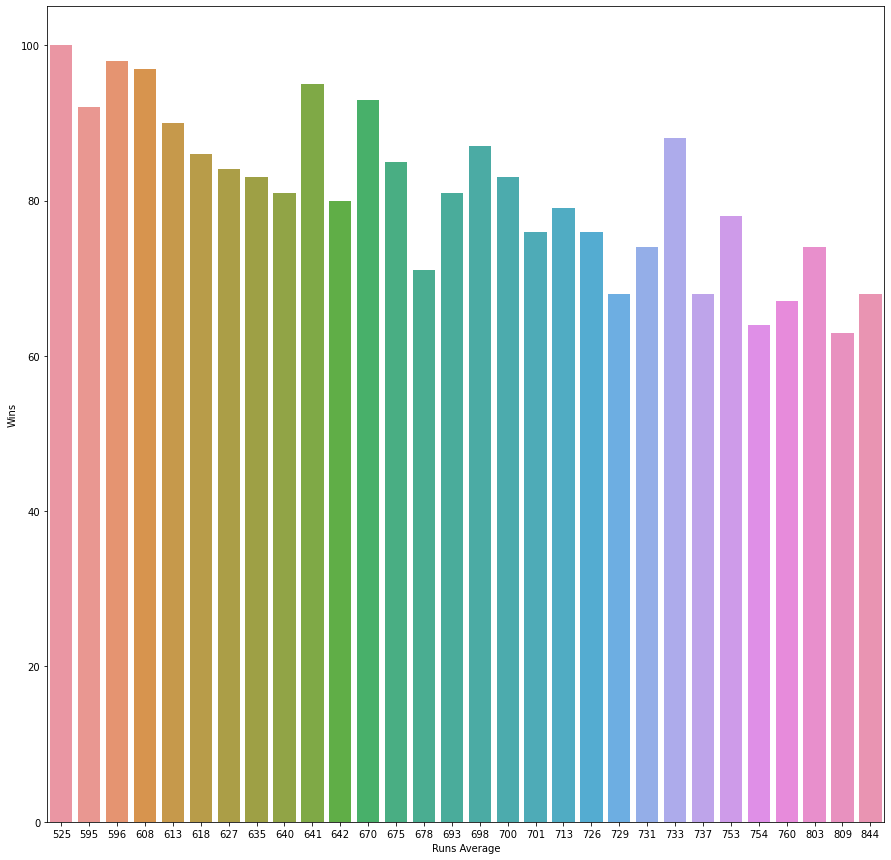

In [28]:
plt.figure(figsize=(15,15))
sns.barplot(x="Runs Average", y="Wins", data=df)
plt.show()

Feature "Runs Average" and it's unique values show a decreasing pattern when it comes to relating with our label "Wins"

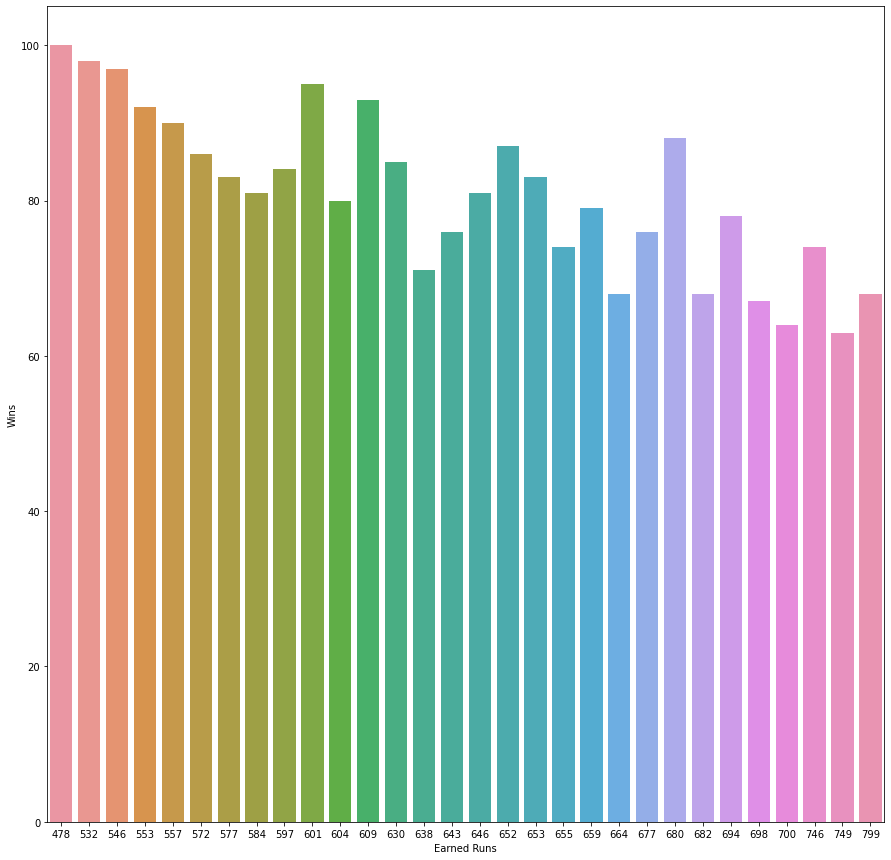

In [29]:
plt.figure(figsize=(15,15))
sns.barplot(x="Earned Runs", y="Wins", data=df)
plt.show()

Feature "Earned Runs" and it's unique values also show a decreasing pattern when it comes to relating with our label "Wins"

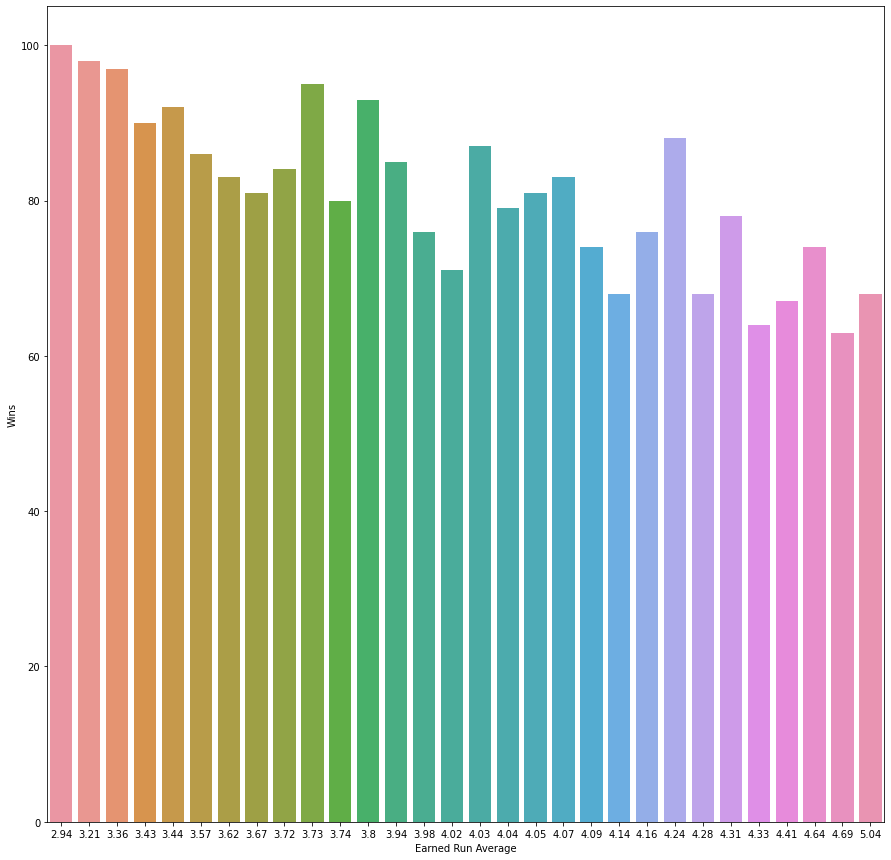

In [30]:
plt.figure(figsize=(15,15))
sns.barplot(x="Earned Run Average", y="Wins", data=df)
plt.show()

Feature "Earned Run Average" and it's unique values are distributed in a slight decreasing order when it comes to relating with our label "Wins"

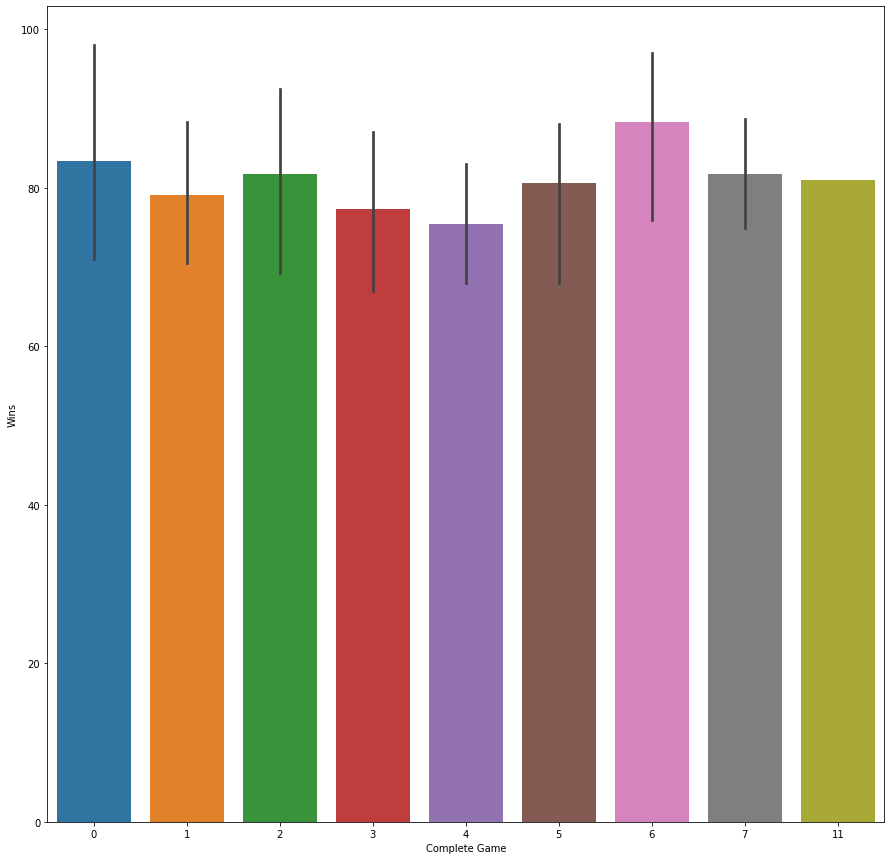

In [31]:
plt.figure(figsize=(15,15))
sns.barplot(x="Complete Game", y="Wins", data=df)
plt.show()

Feature "Complete Game" and it's unique values do not show any pattern when it comes to relating with our label "Wins"

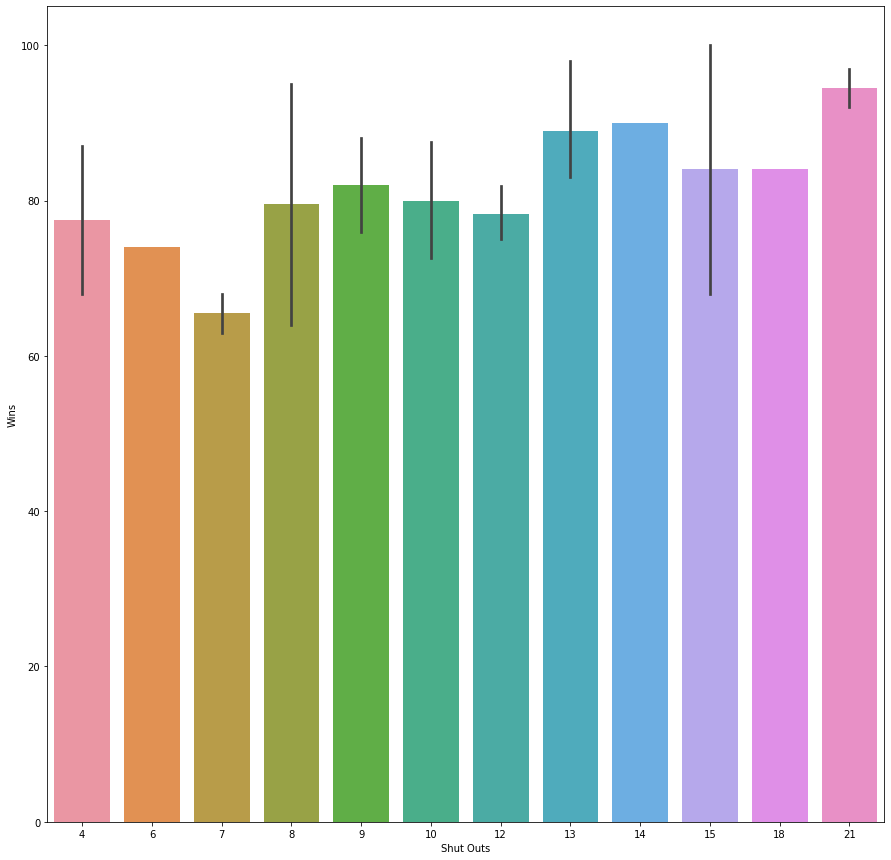

In [32]:
plt.figure(figsize=(15,15))
sns.barplot(x="Shut Outs", y="Wins", data=df)
plt.show()

Feature "Shut Outs" and it's unique values are also distributed unevenly when it comes to relating with our label "Wins"

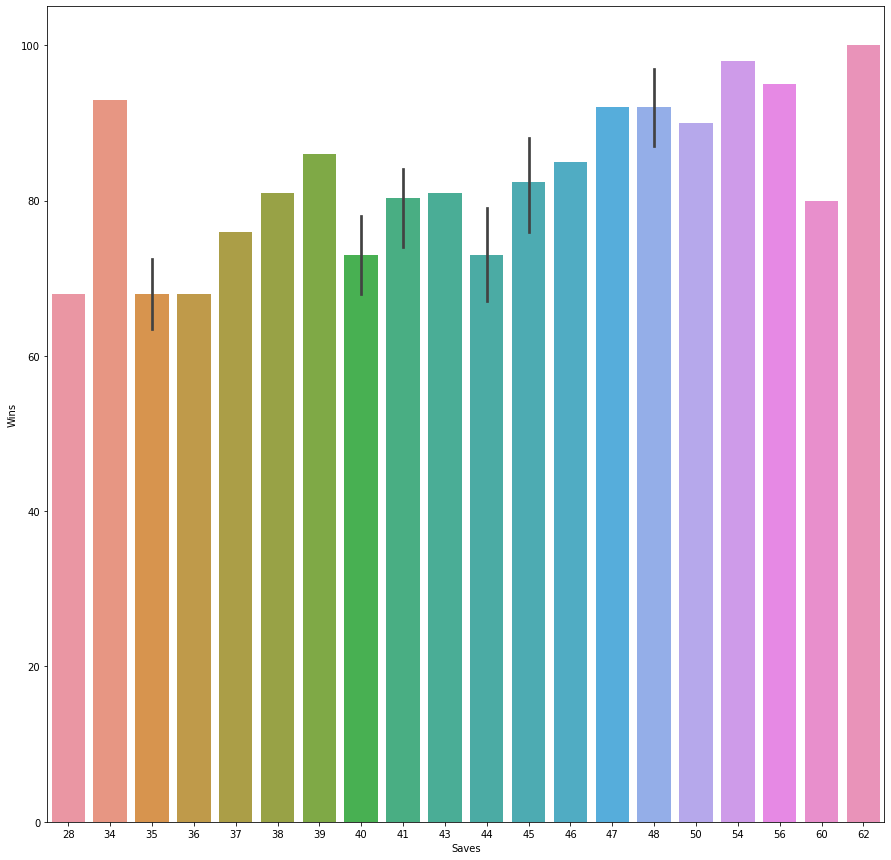

In [33]:
plt.figure(figsize=(15,15))
sns.barplot(x="Saves", y="Wins", data=df)
plt.show()

Feature "Saves" and it's unique values show a slightly increasig pattern when it comes to relating with our label "Wins"

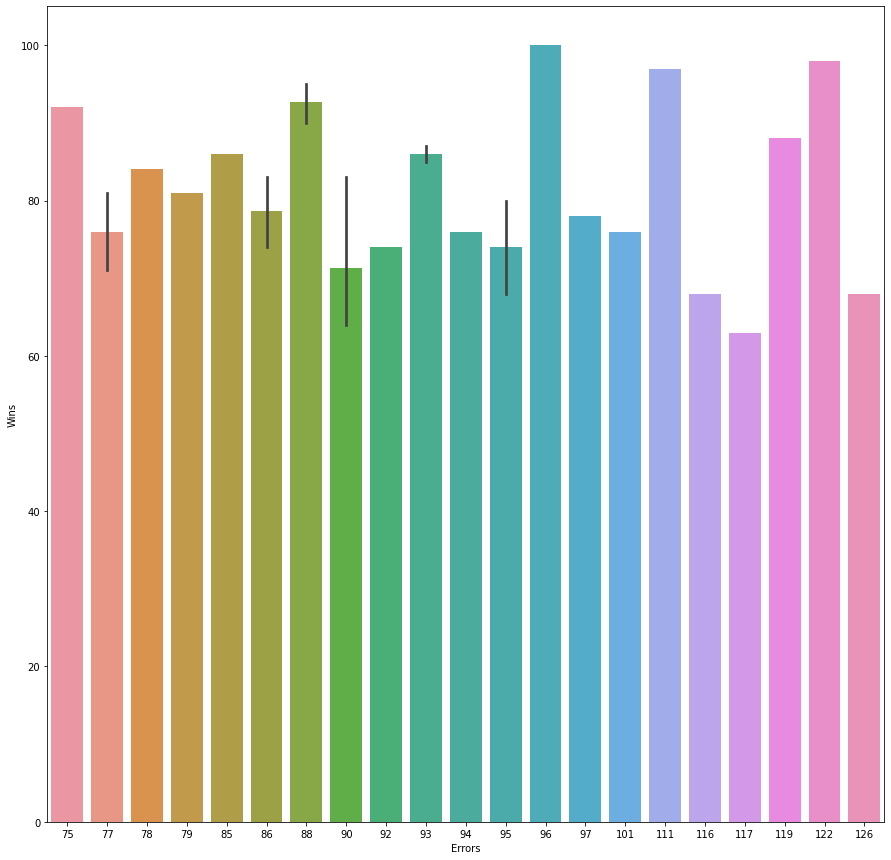

In [34]:
plt.figure(figsize=(15,15))
sns.barplot(x="Errors", y="Wins", data=df)
plt.show()

Feature "Errors" and it's unique values are again distributed unevenly when it comes to relating with our label "Wins"

-> Joint Plot

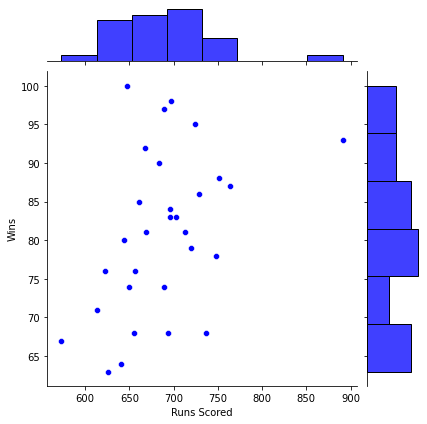

In [35]:
sns.jointplot(x="Runs Scored", y="Wins", data=df, color="blue")

We can say by this plot, as runs are getting higher the chances of winning becomes higher

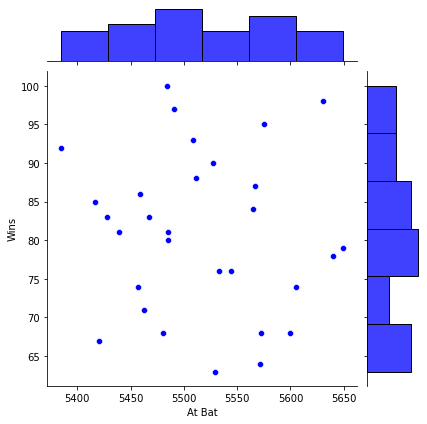

In [36]:
sns.jointplot(x="At Bat", y="Wins", data=df, color="blue")

There is no significant relationship displayed between the label Wins and the feature At Bat and the data points are all over the place

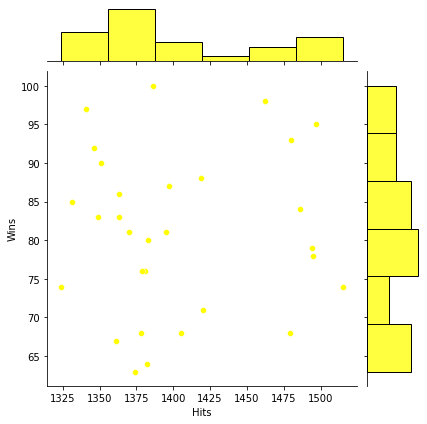

In [37]:
sns.jointplot(x="Hits", y="Wins", data=df, color="yellow")

Even here we can't say there is any linear relation with our target variable and the data points are scattered too

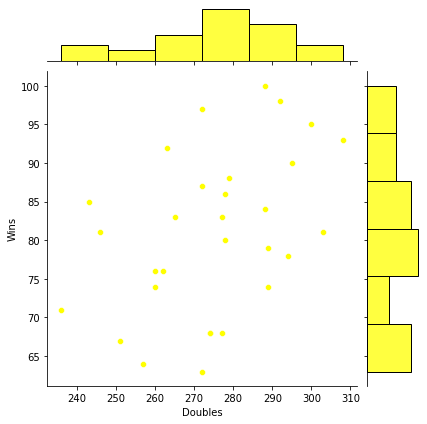

In [38]:
sns.jointplot(x="Doubles", y="Wins", data=df, color="yellow")

We see that if number of doubles are under 250 the chances of win is below 85 and if the number of doubles more than 280 then the chance of wins is more than 85

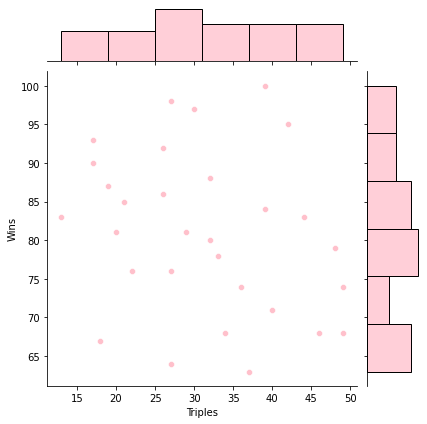

In [39]:
sns.jointplot(x="Triples", y="Wins", data=df, color="pink")

For some reason the data points are scattered showing no relation with the label much and therefore we can say number of triples feature are not much correlated with label wins

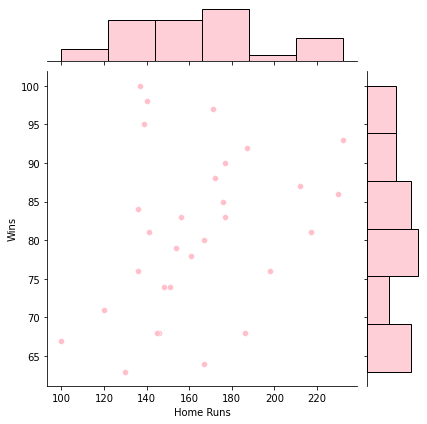

In [40]:
sns.jointplot(x="Home Runs", y="Wins", data=df, color="pink")

By looking at this plot we can say if the number of homeruns is below 140, the chances of wins becoms less

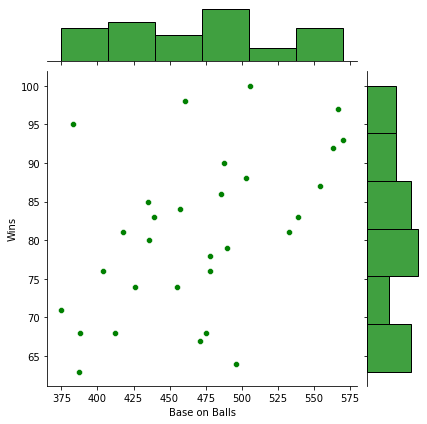

In [41]:
sns.jointplot(x="Base on Balls", y="Wins", data=df, color="green")

In case the base on balls number is above 525 then number of wins are more than 80 But still there is not much relation is observed between this feature and the label variables

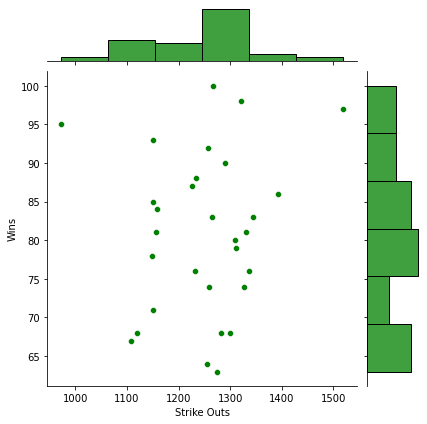

In [42]:
sns.jointplot(x="Strike Outs", y="Wins", data=df, color="green")

In this feature plot it is not showing any linear relation with number of wins

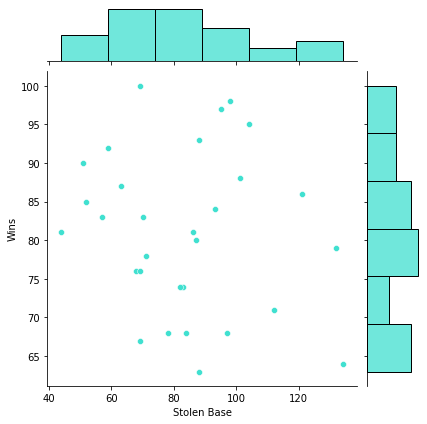

In [43]:
sns.jointplot(x="Stolen Base", y="Wins", data=df, color="turquoise")

A stolen base happens when a base runner proceeds by capturing a base to which they are not entitled to and here if stolen base is between 40 to 60 the number of wins are above 80

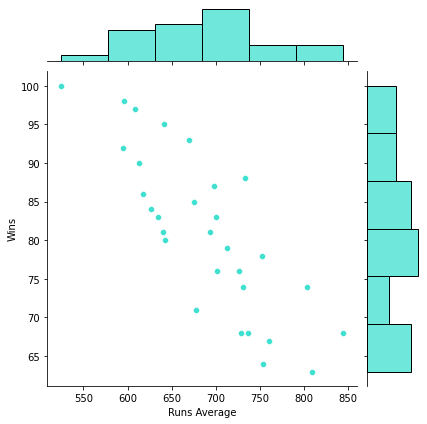

In [44]:
sns.jointplot(x="Runs Average", y="Wins", data=df, color="turquoise")

By observing the above plot we can say that Runs Average are negatively related to number of wins, that is because as the Runs Average number increases the win possibility decreases

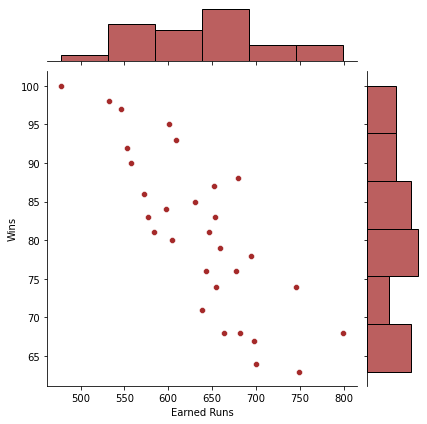

In [48]:
sns.jointplot(x="Earned Runs", y="Wins", data=df, color="brown")

Just like the Runs Average number, Earned Runs also negatively impacts to number of wins

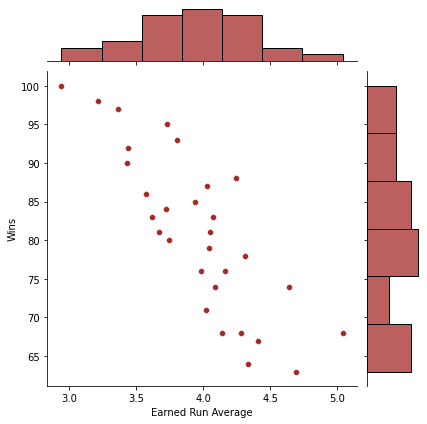

In [49]:
sns.jointplot(x="Earned Run Average", y="Wins", data=df, color="brown")

Earned Runs Average is negatively related to number of wins and is completely depends on feature Earned Runs

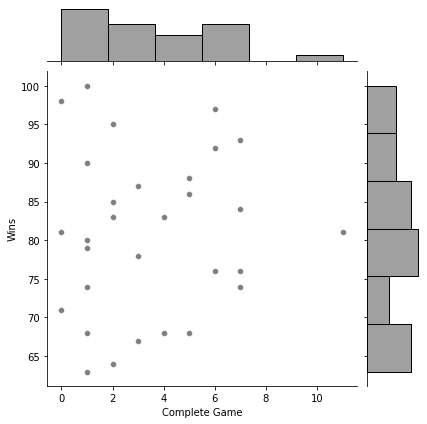

In [51]:
sns.jointplot(x="Complete Game", y="Wins", data=df, color="grey")

We can see that as number of complete games goes above 6 then the number of wins is more than 75 and there is an outlying data present too

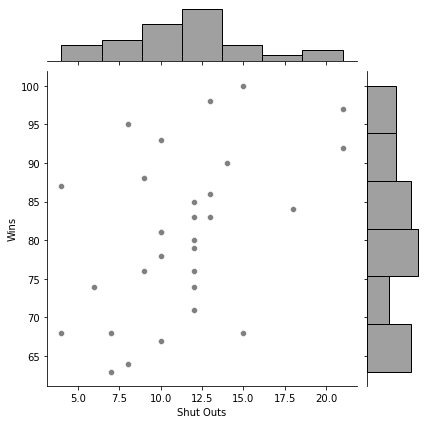

In [52]:
sns.jointplot(x="Shut Outs", y="Wins", data=df, color="grey")

A shut out refers to the act by which a single pitcher pitches a complete game and does not allow the opposing team to score a run so here as the shout outs rise the wins number increases too

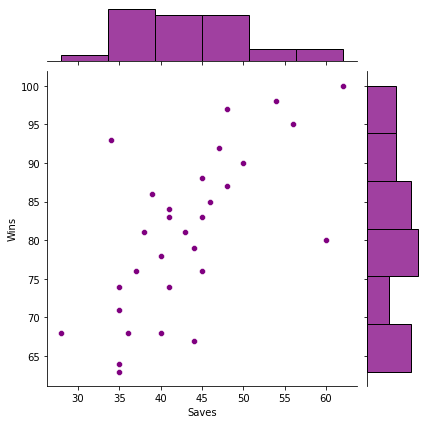

In [53]:
sns.jointplot(x="Saves", y="Wins", data=df, color="purple")

A save is rewarded to the relief pitcher who finishes a game for the winning team under certain circumstances so here as the number of save goes higher the number of wins also increases

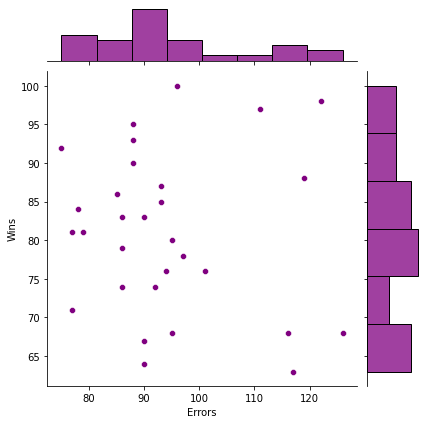

In [54]:
sns.jointplot(x="Errors", y="Wins", data=df, color="purple")

In baseball statistics an error is an act in the judgment of the official scorer of a fielder misplaying a ball in a manner that allows a batter or baserunner to advance one or more bases or allows a plate appearance to continue after the batter should have been put out. So here the number of errors are more in the range of 70 to 100 impacting the wins

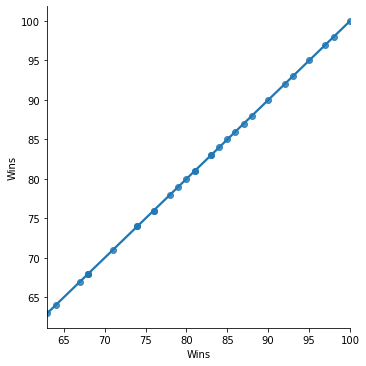

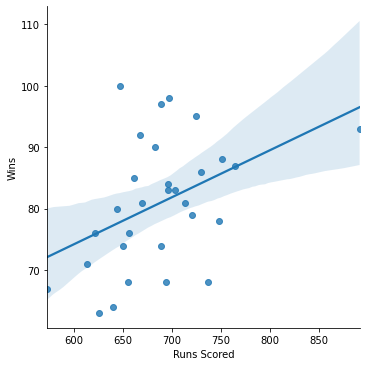

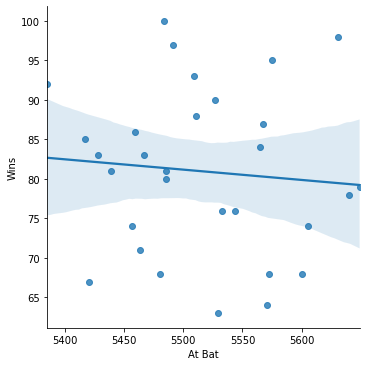

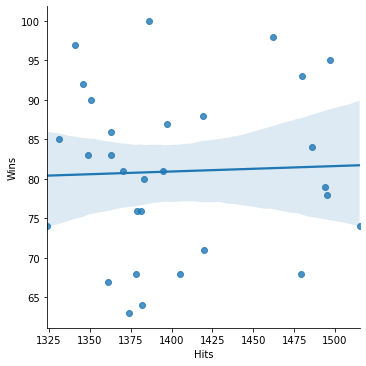

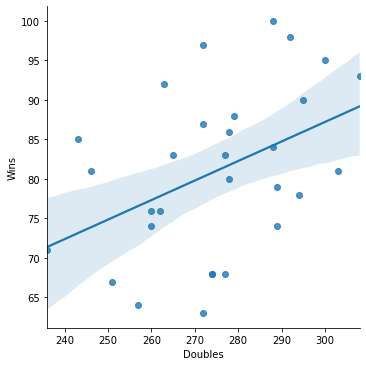

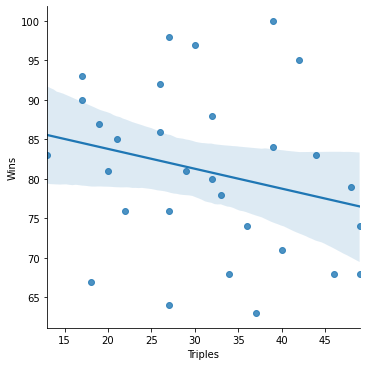

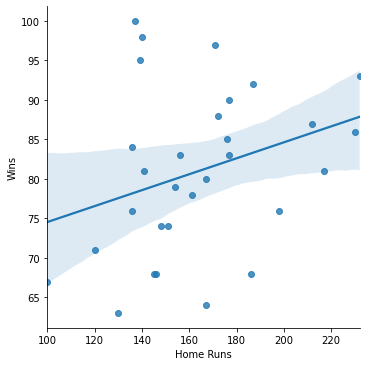

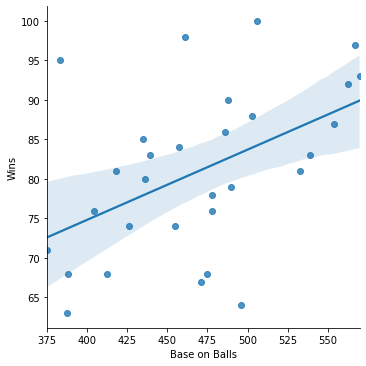

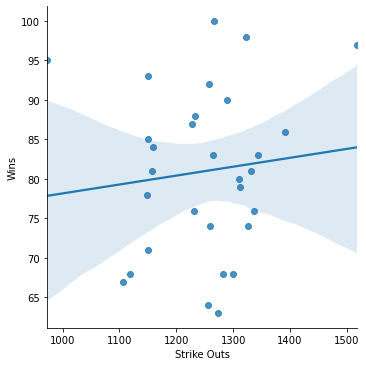

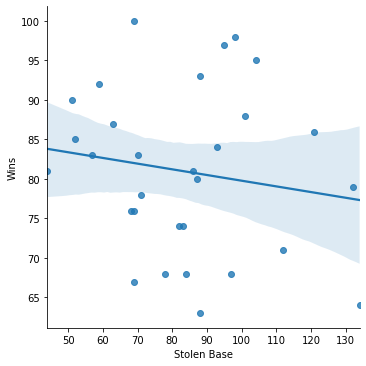

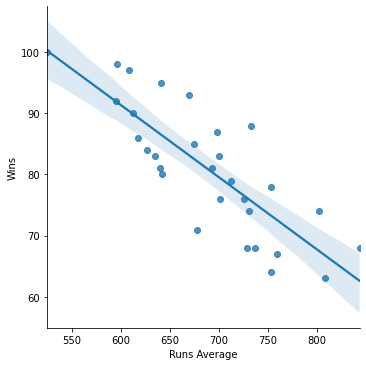

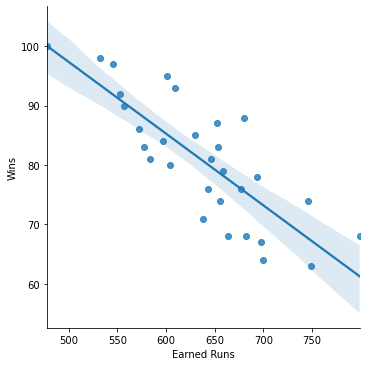

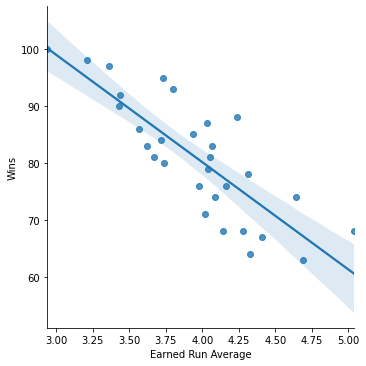

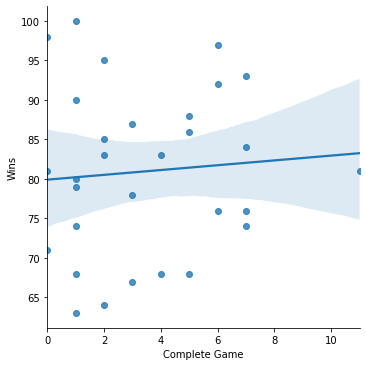

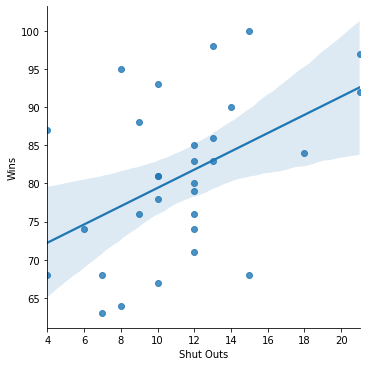

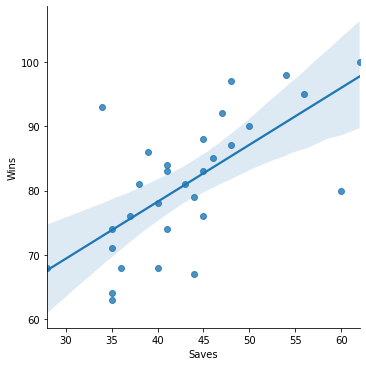

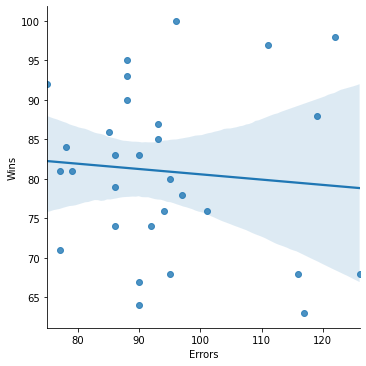

In [55]:
for i in df:
    sns.lmplot(x = i , y ='Wins' , data = df)

From above plot we can see that runs is directly proportional to wins, At Bats is inversely proportional to wins, Hits is not much impacted by Wins, Doubles is proportional to Wins, Triples is again proportional to Wins, Home runs is proportional to Wins, Walks is also proportional to wins, Strike out is proportional to wins, Stolen bases is proportional to Wins, Runs allowed is inversely proportional to Wins, Earned runs is again inversely proportional to Wins, Earned runs average is also inversely proportional to Wins, Wins is somewhat affected by the number of Complete Games, Wins is slightly affected by shut outs and Wins is directly propertional to Saves.

Multivariate Analysis

-> Pair Plot

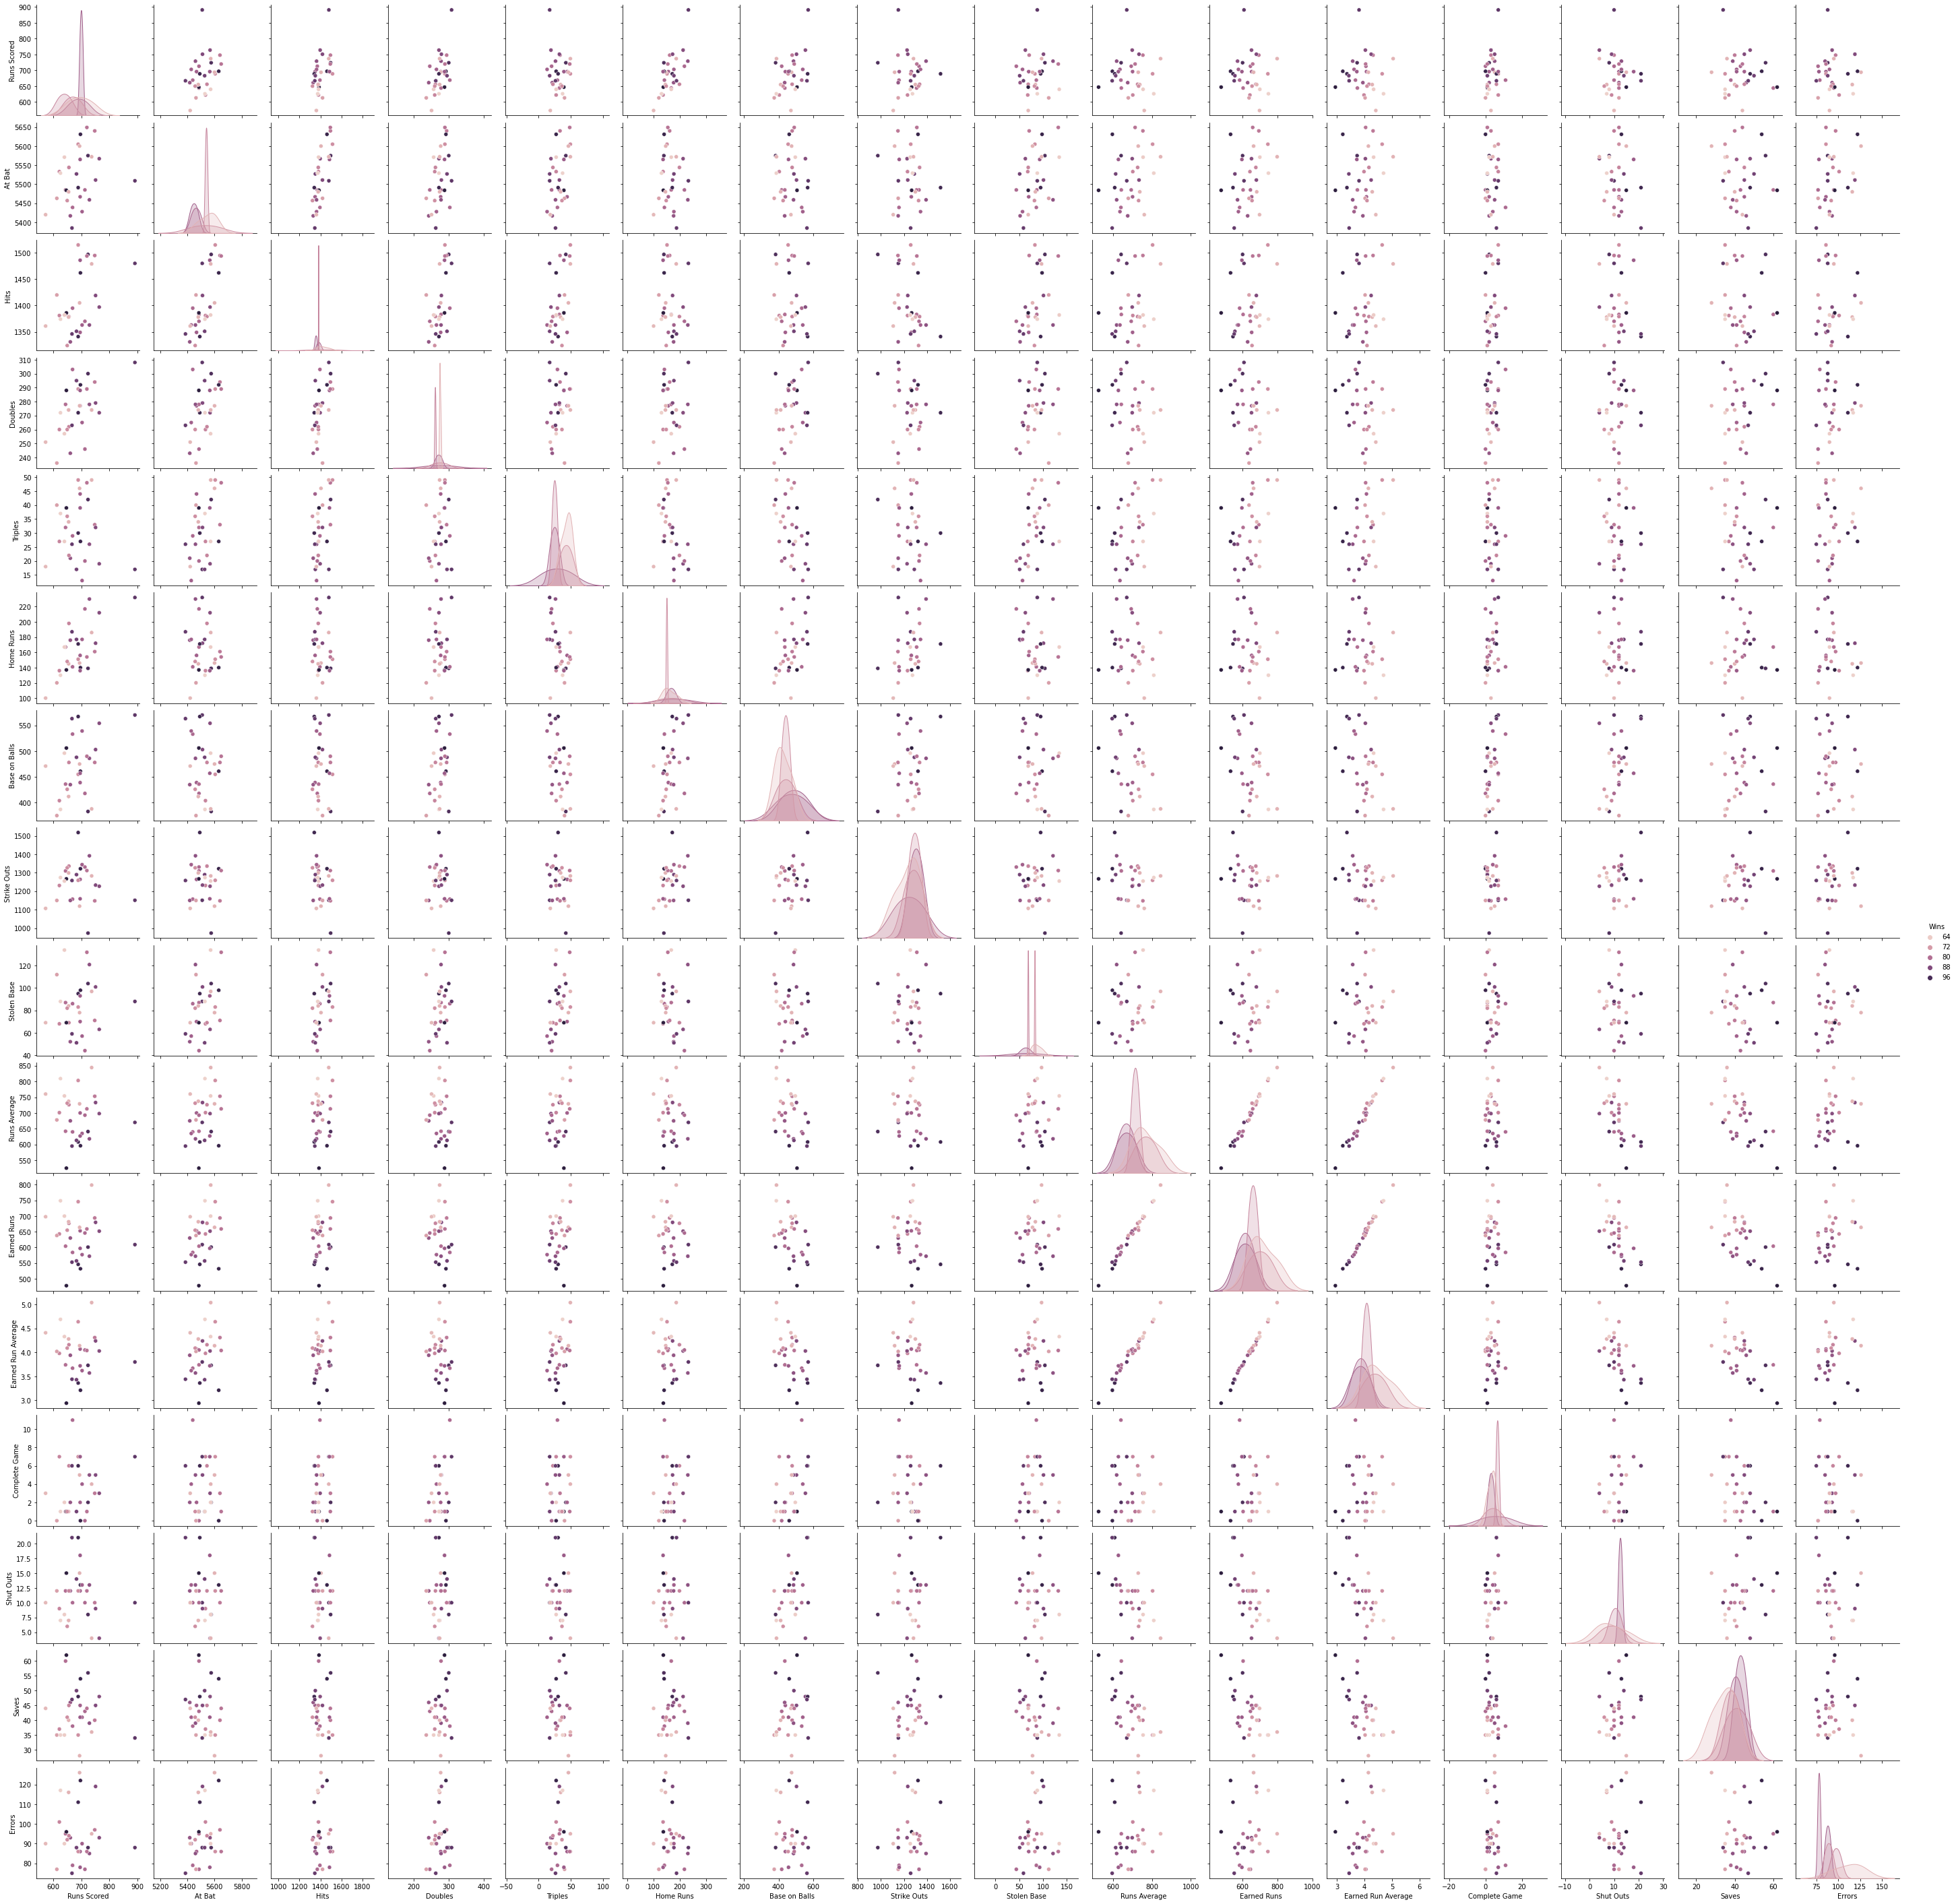

In [56]:
sns.pairplot(df, hue="Wins")

Since there are 17 columns present in our dataset making a pairplot for all of them has given us a very tiny image with an unreadable format therefore we will take help of a heatmap to get the collinearity details for the columns in our dataset.

-> Correlation using a Heatmap

1. Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.

2. Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down.

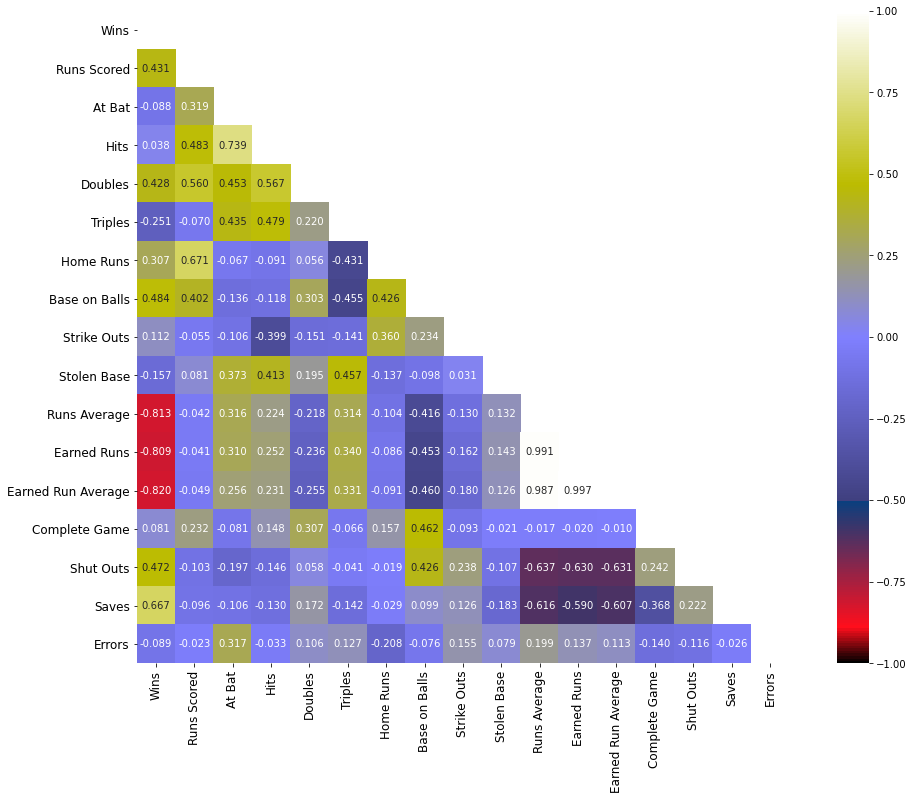

In [57]:
upper_triangle = np.triu(df.corr())
plt.figure(figsize=(17,12))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', 
            annot_kws={'size':10}, cmap="gist_stern", mask=upper_triangle)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In the above heatmap we see that our label "Wins" column is showing negatively correlated with feature columns "Runs Average", "Earned Runs" and "Earned Run Average". Also there is visible multi colinearity between the feature columns "Earned Runs", "Earned Run Average" and "Runs Average" data points. We may need to drop highly correlated columns to avoid this issue or I may try to make use of PCA to reduce the multi collearnig concern ahead before the model building phase.

In [58]:
df = df.drop(["Earned Runs", "Earned Run Average"], axis=1)

Since the feature columns "Earned Runs" and "Earned Run Average" have a high collinearity with the column "Runs Average" where all 3 are negatively correlated with our label column "Wins" therefore dropping the other two to avoid multi collinearity issue in our model.

Outlier removal using Z Score

In [59]:
z = np.abs(zscore(df))
threshold = 3
df1 = df[(z<3).all(axis = 1)]

print ("Shape of the dataframe before removing outliers: ", df.shape)
print ("Shape of the dataframe after removing outliers: ", df1.shape)
print ("Percentage of data loss post outlier removal: ", (df.shape[0]-df1.shape[0])/df.shape[0]*100)

df=df1.copy() # reassigning the changed dataframe name to our original dataframe name

Shape of the dataframe before removing outliers:  (30, 15)
Shape of the dataframe after removing outliers:  (29, 15)
Percentage of data loss post outlier removal:  3.3333333333333335


We are using the Z score method to remove any outlier that we could afford to lose from our original dataset. I see that since there were not many data points removed our new dataset would still have outlier traces but I would like to retain them.

-> Box Plot

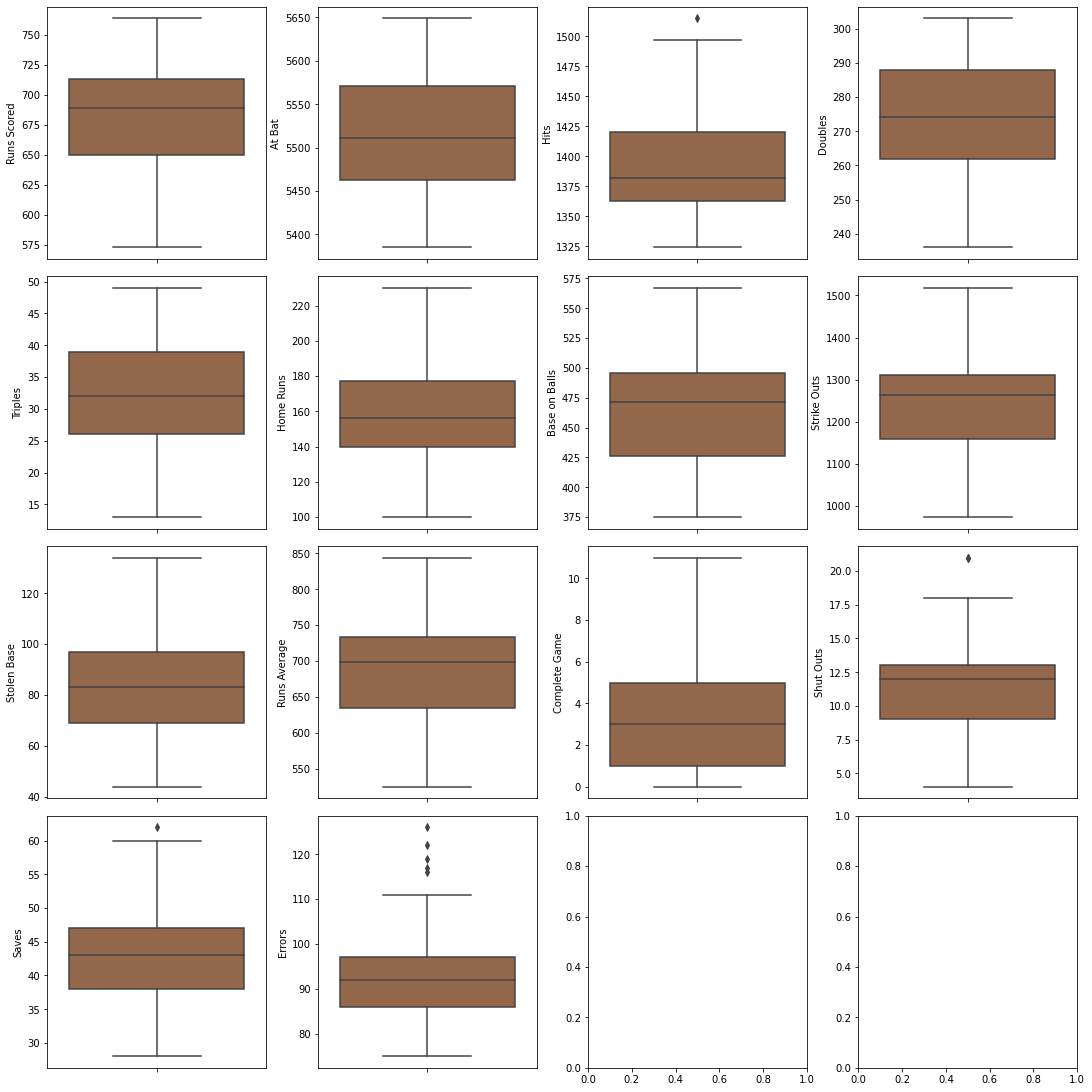

In [61]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(15,15))
index = 0
features = df.drop("Wins", axis=1)
ax = ax.flatten()
for col, value in features.items():
    sns.boxplot(y=col, data=df, ax=ax[index], palette="copper")
    index += 1
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
plt.show()

There are light traces of outliers still present in our dataset but I think I will not remove any more information from my now updated dataset. Using the existing data to building the machine learning model.

In [62]:
df.skew()

Wins             0.119013
Runs Scored     -0.215364
At Bat           0.169573
Hits             0.783772
Doubles         -0.335304
Triples          0.090124
Home Runs        0.450862
Base on Balls    0.151193
Strike Outs     -0.233815
Stolen Base      0.494966
Runs Average     0.018155
Complete Game    0.854980
Shut Outs        0.526943
Saves            0.627480
Errors           0.840271
dtype: float64

I can see that there are still few columns showing slight skewness but overall it seems that they are either withing the acceptable range or very near to the acceptable range of skewness that is +/-0.5.

-> Distribution Plot

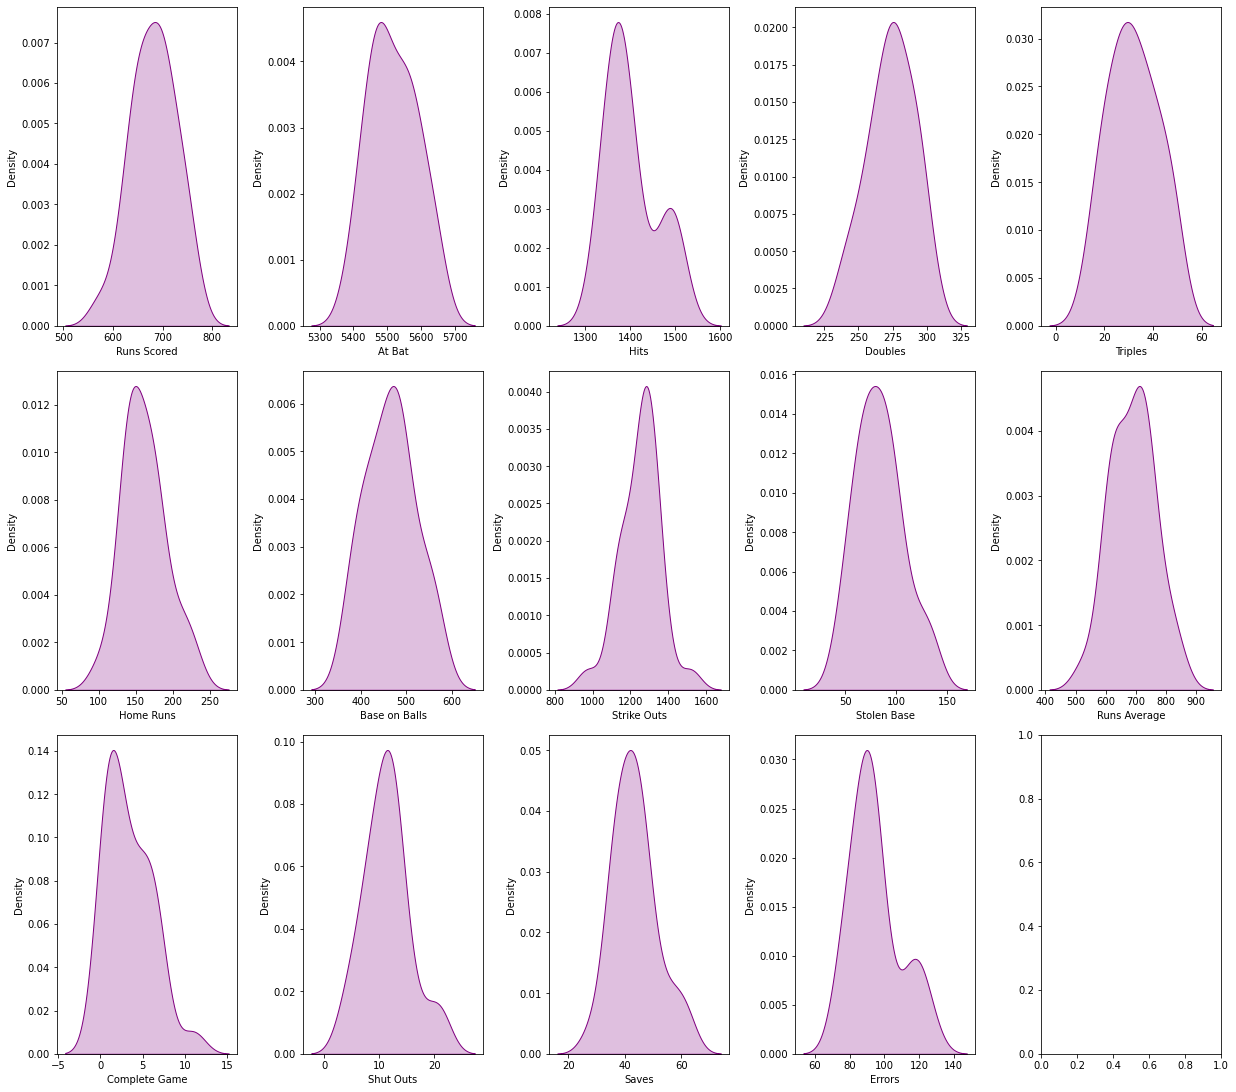

In [64]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(17,15))
index = 0
features = df.drop("Wins", axis=1)
ax = ax.flatten()
for col, value in features.items():
    sns.distplot(value, ax=ax[index], hist=False, color="purple", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
plt.show()

After taking a look at the above distribution plot we can see that almost all of the feature columns are able to show a bell shape curve indicating towards a normalized dataset.

In [65]:
X = df.drop('Wins', axis=1)
Y = df['Wins']

We have bifurcated the dataset into features and labels where X represents all the feature columns and Y represents the target label column

Feature Scaling

In [66]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head(10)

,Runs Scored,At Bat,Hits,Doubles,Triples,Home Runs,Base on Balls,Strike Outs,Stolen Base,Runs Average,Complete Game,Shut Outs,Saves,Errors
0,0.959398,0.830084,1.738306,1.556538,1.010845,-0.765863,-1.536359,-2.727623,0.905953,-0.664514,-0.501486,-0.813262,1.643157,-0.471091
1,0.331147,-0.702831,-0.938698,0.201171,1.208917,-0.181389,-0.495021,0.121896,-0.585315,0.154638,-0.501486,0.159299,0.211006,-0.614898
2,-0.274666,-1.100253,-0.106656,1.733325,-0.276617,-0.697101,1.252941,-0.925866,0.116458,-0.678397,2.854612,-0.326982,-0.700362,-1.118222
3,-1.329231,0.233951,-0.359886,-0.800621,-0.474688,-0.869006,-1.145857,-0.201246,-0.673037,0.168522,1.363013,-0.570122,-0.830557,0.463653
4,0.174084,1.255894,2.063888,0.908319,1.704094,-0.353293,-0.197495,0.072935,-0.015124,1.584683,1.363013,0.159299,-1.090948,-0.614898
5,1.856900,0.716535,-0.070480,-0.093474,-1.266972,1.743939,1.643442,-0.240414,-0.892341,0.126870,-0.128586,-1.785822,0.601593,-0.111574
6,0.712585,-0.447345,-0.558853,-1.625627,-1.167936,1.915843,-0.885522,0.777970,-1.725697,0.057451,-1.247285,-0.326982,-0.049384,-1.262029
7,-0.835605,-0.447345,-0.323710,0.260100,0.020490,0.196801,-0.550807,0.572335,0.160319,-0.650630,-0.874386,0.159299,2.163939,0.032233
8,1.497899,1.752672,1.702131,1.202964,0.119526,-0.009484,0.230197,-1.013995,-0.541454,0.890486,-0.128586,-0.326982,-0.439971,0.176039
9,1.565212,-0.078310,0.327453,0.319029,0.020490,0.368705,0.695081,-0.181661,0.774370,0.612808,0.617213,-0.570122,0.211006,1.757915


We are scaling the feature data to ensure that there is no issue with the data biasness over a particular column instead a standardization will occur helping us in having a uniform dataset value.

Principal component analysis (PCA)

In [67]:
pca = PCA(n_components=14, svd_solver="full")
X = pd.DataFrame(pca.fit_transform(X), columns=X.columns)
X.head(10)

,Runs Scored,At Bat,Hits,Doubles,Triples,Home Runs,Base on Balls,Strike Outs,Stolen Base,Runs Average,Complete Game,Shut Outs,Saves,Errors
0,-2.957996,-0.953253,2.246316,-1.216994,-2.357314,0.016125,0.626783,0.394846,0.882534,0.554004,-0.258275,-0.218896,-0.176119,0.192275
1,0.240394,0.417411,0.313526,-0.266703,-0.294763,0.504699,-0.962596,1.240400,0.256176,-0.827710,0.332404,-0.199270,-0.010978,0.486047
2,0.474141,-1.106621,0.911147,3.099281,-0.796596,-0.762581,1.542021,1.355597,-0.235204,0.159777,0.549155,0.082016,0.205976,-0.116133
3,-0.109473,1.848198,0.163538,1.093046,0.300077,-1.019805,-0.127039,0.024300,-0.562258,1.324900,-0.151055,-0.102882,0.737932,0.222658
4,-2.909976,-0.777732,-0.319362,1.853279,-0.148994,0.213535,-1.046595,0.188747,-1.268692,-0.264274,-0.364419,0.118457,-0.147223,-0.268420
5,0.667623,-1.404411,-2.424945,-0.966726,-1.725726,-1.119576,1.016351,-0.453021,0.101003,-0.685705,-0.280422,-0.149604,0.698599,-0.025234
6,1.947763,0.997051,-2.042951,-1.258751,-1.728523,0.792559,-1.306637,-0.455940,-0.201846,0.328548,0.206196,0.220391,0.094941,-0.003327
7,0.939941,-0.062020,1.197914,-1.850466,0.162508,0.548143,0.150741,0.700940,-0.481820,0.298089,-0.687803,-0.378809,-0.342151,-0.146316
8,-2.383972,-1.433303,-0.623188,-0.034015,-1.169926,-1.165087,-0.411894,-0.856657,-0.244877,-0.377093,0.350590,0.165218,-0.282090,0.028534
9,-0.883912,-1.117449,-1.155980,-0.166050,0.614701,-1.047468,0.786800,0.361866,1.213722,-0.148495,-0.822724,0.475524,-0.306328,0.150268


Used the PCA techniques so that it can help us in reducing the skewness present in our dataset even though ideally PCA is used for reducing dimentionality (curse of dimentionality) on bigger dataset I am using this to check if it can assist with the skewness concern.

Power Transformation

In [68]:
p_transform = PowerTransformer(method = 'yeo-johnson')
X = pd.DataFrame(p_transform.fit_transform(X), columns=X.columns)
X.head(10)

,Runs Scored,At Bat,Hits,Doubles,Triples,Home Runs,Base on Balls,Strike Outs,Stolen Base,Runs Average,Complete Game,Shut Outs,Saves,Errors
0,-1.531314,-0.498970,1.648944,-1.012066,-2.313643,0.160763,0.858484,0.615354,1.330458,1.040373,-0.514105,-0.560659,-0.467027,0.926858
1,0.107095,0.491777,0.264410,-0.152456,-0.222672,0.618698,-1.355468,1.627497,0.506216,-1.732195,0.707081,-0.507797,0.121365,2.093866
2,0.231348,-0.637813,0.701913,2.267201,-0.705892,-0.741631,1.791532,1.755747,-0.285770,0.395032,1.130860,0.236013,0.754554,-0.513110
3,-0.077322,1.155694,0.152658,0.908262,0.317725,-1.081383,-0.067982,0.116307,-0.903286,2.107384,-0.284258,-0.249929,1.884386,1.055454
4,-1.507224,-0.346199,-0.214158,1.442298,-0.086620,0.354539,-1.497998,0.343404,-2.446157,-0.425055,-0.744902,0.330416,-0.356914,-1.324429
5,0.334721,-0.920914,-1.898773,-0.777902,-1.647266,-1.218018,1.274056,-0.601532,0.273842,-1.381634,-0.562001,-0.374556,1.814975,-0.060628
6,1.027540,0.787104,-1.585944,-1.051603,-1.650175,0.860395,-1.952420,-0.606167,-0.226670,0.682387,0.455062,0.592304,0.447967,0.044761
7,0.480910,0.201045,0.908332,-1.624805,0.196177,0.656288,0.297876,0.998391,-0.745228,0.631872,-1.465975,-0.995567,-1.159171,-0.668680
8,-1.242640,-0.949294,-0.449948,0.043601,-1.077768,-1.281211,-0.478003,-1.267010,-0.303047,-0.668205,0.743058,0.450942,-0.897050,0.195479
9,-0.479206,-0.647799,-0.870502,-0.066799,0.589530,-1.119003,1.033087,0.572677,1.713964,-0.186051,-1.774019,1.235321,-1.001225,0.745612


Using the 'yeo-johnson' method as 'box-cox' can be used only on positive data. With the help of Power Transformation our outliers should be handled too. Since we do not have much data we are trying not to lose any rows by removing outliers right now. However if needed to increase the accuracy of our model we may perform outlier removal later on.

Variance Inflation Factor(VIF)

In [69]:
vif_data = pd.DataFrame()
vif_data["Features List"]=X.columns
vif_data["VIF Value"]=[variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data

,Features List,VIF Value
0,Runs Scored,1.006200
1,At Bat,1.017150
2,Hits,1.005998
3,Doubles,1.007102
4,Triples,1.005601
5,Home Runs,1.011452
6,Base on Balls,1.013386
7,Strike Outs,1.007557
8,Stolen Base,1.010934
9,Runs Average,1.002451


In theory if a VIF is above 10 it indicates high correlation and is cause for concern. Right now we have almost all the feature columns within the range of intended VIF value. This definitely gives us a green signal on creating our machine learning model.

In [70]:
X.skew()

Runs Scored      0.019135
At Bat           0.138663
Hits             0.002219
Doubles          0.010464
Triples          0.012446
Home Runs        0.073433
Base on Balls    0.004156
Strike Outs      0.028031
Stolen Base     -0.068430
Runs Average     0.049740
Complete Game    0.061566
Shut Outs        0.019880
Saves            0.046013
Errors           0.003803
dtype: float64

We are taking a look at the skewness details for our feature columns and even though we see the values out of range they do not seem to have any kind of abnormality and we will confirm the same using a distribution plot and visualize it.

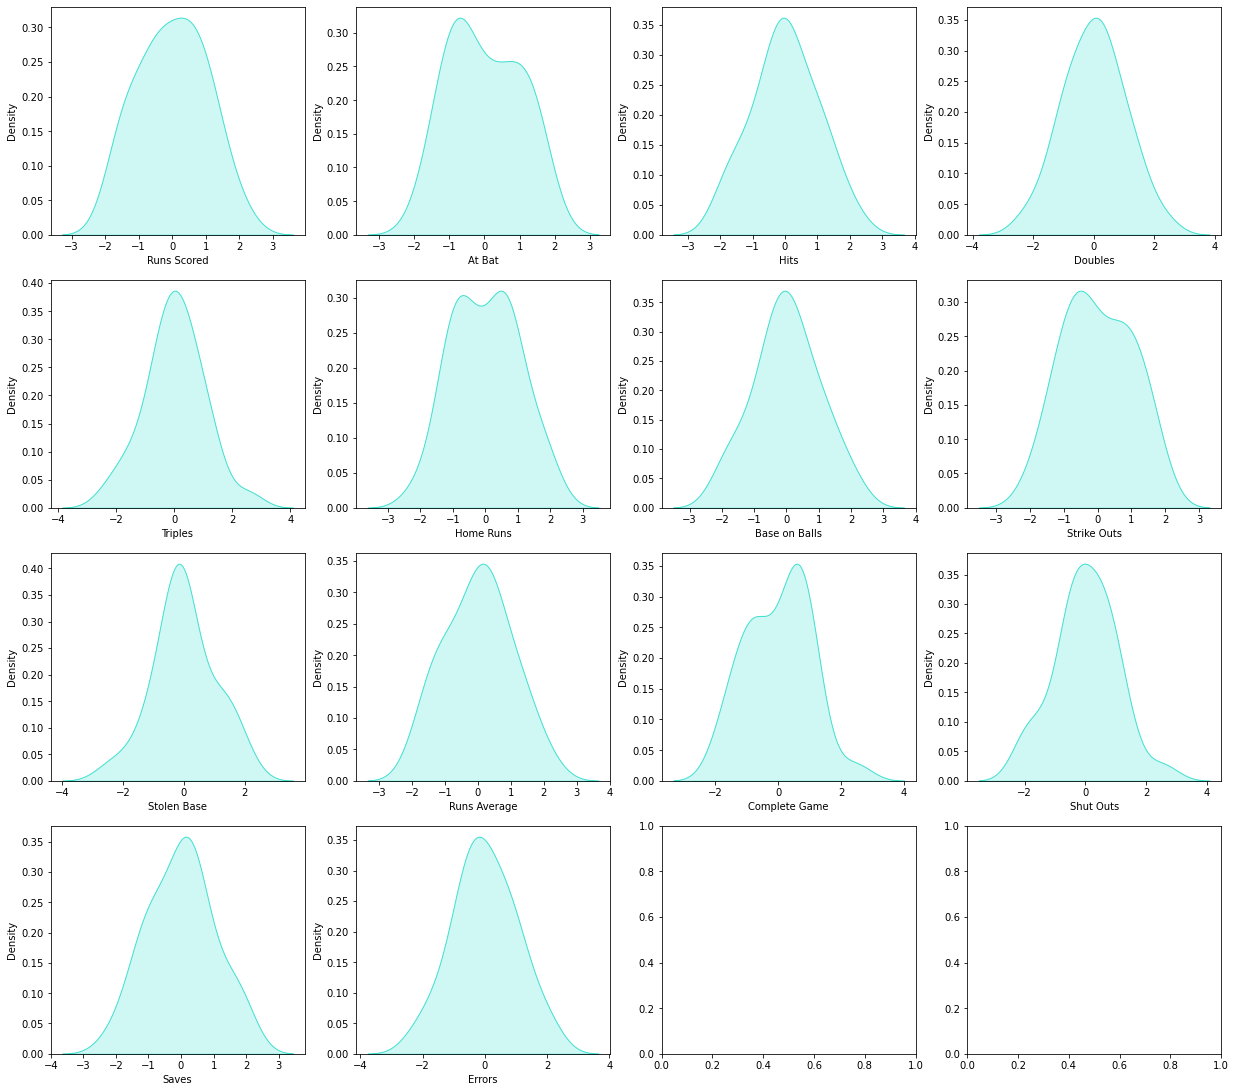

In [71]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(17,15))
index = 0
ax = ax.flatten()
for col, value in X.items():
    sns.distplot(value, ax=ax[index], hist=False, color="turquoise", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=1.0)
plt.show()

As we can see in the above distribution plot all the values are being reflected in proper normalized formated showing a bell shape curve format.

Finding best random state for building Regression Models

In [72]:
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LinearRegression()
    lr.fit(X_train, Y_train)
    pred = lr.predict(X_test)
    r2 = r2_score(Y_test, pred)
    
    if r2>maxAccu:
        maxAccu=r2
        maxRS=i

print("Best r2 score is", maxAccu,"on Random State", maxRS)

Best r2 score is 0.9354003729249138 on Random State 708


Creating the training and testing data sets

In [73]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=708)

We are taking 25 percent of the complete dataset for training purpose and the remaing 75 percent with be used to train the machine learning models

Machine Learning Model for Regression with Evaluation Metrics

In [74]:
# Regression Model Function

def reg(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=708)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # RMSE - a lower RMSE score is better than a higher one
    rmse = mean_squared_error(Y_test, pred, squared=False)
    print("RMSE Score is:", rmse)
    
    # R2 score
    r2 = r2_score(Y_test, pred, multioutput='variance_weighted')*100
    print("R2 Score is:", r2)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of r2 score minus cv score
    result = r2 - cv_score
    print("R2 Score - Cross Validation Score is", result)

We have built a function that splits the training and testing features and labels, then trains the model, predicts the label, calculates the RMSE score, generates the R2 score, calculates the Cross Validation score and finally finds the difference between the R2 score and Cross Validation score.

In [75]:
# Linear Regression Model

model=LinearRegression()
reg(model, X, Y)

RMSE Score is: 3.1488146002666917
R2 Score is: 93.54003729249139
Cross Validation Score: 23.06111679863145
R2 Score - Cross Validation Score is 70.47892049385995


In [76]:
# Ridge Regression

model=Ridge(alpha=1e-2, normalize=True)
reg(model, X, Y)

RMSE Score is: 3.2617077160697034
R2 Score is: 93.06852099761383
Cross Validation Score: 24.99930075545885
R2 Score - Cross Validation Score is 68.06922024215498


In [77]:
# Lasso Regression

model=Lasso(alpha=1e-2, normalize=True, max_iter=1e5)
reg(model, X, Y)

RMSE Score is: 3.5967315659365173
R2 Score is: 91.5714691105175
Cross Validation Score: 25.91211144649591
R2 Score - Cross Validation Score is 65.65935766402158


In [78]:
# Support Vector Regression

model=SVR(C=1.0, epsilon=0.2, kernel='poly', gamma='auto')
reg(model, X, Y)

RMSE Score is: 12.416554604501803
R2 Score is: -0.44724633799038127
Cross Validation Score: -44.95227038405757
R2 Score - Cross Validation Score is 44.50502404606719


In [79]:
# Decision Tree Regressor

model=DecisionTreeRegressor(criterion="poisson", random_state=111)
reg(model, X, Y)

RMSE Score is: 11.241663577958558
R2 Score is: 17.662628524890568
Cross Validation Score: -173.3181896424058
R2 Score - Cross Validation Score is 190.98081816729638


In [80]:
# Random Forest Regressor

model=RandomForestRegressor(max_depth=2, max_features="sqrt")
reg(model, X, Y)

RMSE Score is: 11.285276523697705
R2 Score is: 17.0225202296178
Cross Validation Score: -10.053166982171893
R2 Score - Cross Validation Score is 27.075687211789692


In [81]:
# K Neighbors Regressor

KNeighborsRegressor(n_neighbors=2, algorithm='kd_tree')
reg(model, X, Y)

RMSE Score is: 11.085057766935435
R2 Score is: 19.940706865897173
Cross Validation Score: 0.2172168185266843
R2 Score - Cross Validation Score is 19.72349004737049


In [82]:
# Gradient Boosting Regressor

model=GradientBoostingRegressor(loss='quantile', n_estimators=200, max_depth=5)
reg(model, X, Y)

RMSE Score is: 10.089126065604539
R2 Score is: 33.68024284709051
Cross Validation Score: -179.90109295592433
R2 Score - Cross Validation Score is 213.58133580301484


In [83]:
# Ada Boost Regressor

model=AdaBoostRegressor(n_estimators=300, learning_rate=1.05, random_state=42)
reg(model, X, Y)

RMSE Score is: 8.479806486916761
R2 Score is: 53.150203038220944
Cross Validation Score: -28.707085426328394
R2 Score - Cross Validation Score is 81.85728846454934


In [84]:
# Extra Trees Regressor

model=ExtraTreesRegressor(n_estimators=200, max_features='sqrt', n_jobs=6)
reg(model, X, Y)

RMSE Score is: 10.322709794428983
R2 Score is: 30.573820625063597
Cross Validation Score: 3.1650704706537325
R2 Score - Cross Validation Score is 27.408750154409866


In [85]:
# XGB Regressor

model=XGBRegressor()
reg(model, X, Y)

RMSE Score is: 14.637451963447377
R2 Score is: -39.59401403708325
Cross Validation Score: 0.8835494861448033
R2 Score - Cross Validation Score is -40.47756352322805


Hyper parameter tuning on the best ML Model

In [86]:
# Choosing Linear Regression

fmod_param = {'fit_intercept' : [True, False],
              'normalize' : [True, False],
              'copy_X' : [True, False],
              'positive' : [True, False],
              'n_jobs' : [-2, -1, 1]
             }

After comparing all the regression models we have selected Linear Regression as my best model and have listed down it's parameters above referring the sklearn webpage

In [87]:
GSCV = GridSearchCV(LinearRegression(), fmod_param, cv=5)

Using the Grid Search CV method for hyper parameter tuning our best model.

In [88]:
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False], 'n_jobs': [-2, -1, 1],
                         'normalize': [True, False],
                         'positive': [True, False]})

We have trained the Grid Search CV with the list of parameters

In [89]:
GSCV.best_params_

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': -2,
 'normalize': True,
 'positive': True}

The Grid Search CV has provided us with the best parameters list out of all the combinations it used to train the model

In [90]:
Final_Model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs= -2, normalize=True, positive=True)
Classifier = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_r2 = r2_score(Y_test, fmod_pred)*100
print("R2 score for the Best Model is:", fmod_r2)

R2 score for the Best Model is: -34.12378818710777


Successfully incorporated the Hyper Parameter Tuning on my Final Model and received the R2 score for it

Saving the best model

In [91]:
filename = "FinalModel_Baseball.pkl"
joblib.dump(Final_Model, filename)

['FinalModel_Baseball.pkl']

Saving the best regression model using the joblib library.